In [49]:
# Using uncalibrated airplane data, generate baseline and antenna calibrations for a given day
#
# Author: Brian Pitzel
# Date Created: 3 March 2025
# Date Modified: 1 May 2025

import numpy as np
import h5py 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import get_cmap # cyclic colormap
import colorcet as cc # cyclic colormap
from matplotlib.lines import Line2D
import datetime
import csv
import glob
import pickle
import pymap3d as pm
from datetime import timezone
import warnings
import helpers.airplanes as ap
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib widget

vfromtimestamp = np.vectorize(datetime.datetime.fromtimestamp)
vutcfromtimestamp = np.vectorize(datetime.datetime.utcfromtimestamp)

In [50]:
# hard-coded magic numbers needed for the script

N_BASELINES = 45
RE_KM = 6378

# download aircraft data only if it falls within these lat/lon boundaries
# west, south, east, north
BOUNDS = (-109.375, 50.771, -106.0, 52.765) # old bounds
BOUNDS = (-109.375, 50.8, -106.4, 52.25) # new bounds, more constrained

# locations of the ICEBEAR receiver and transmitter
RX = (52.24393, -106.45025, 0)
TX = (50.893, -109.403, 0)
TX_RX_DISTANCE = 254 # km

# convert feet to meters
FT_TO_M = 1 / 3.281


# plotting stuff
fig_width_inches = 8#17
fig_height_inches = 5#10
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

SMALL_SIZE = 20 #38
MEDIUM_SIZE = 25 #42
BIGGER_SIZE = 30 #56

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE//2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [205]:
# inputs to the script:
# ymd - date of the day to calibrate on (will use data from all 24 hours unless otherwise specified)
# level1_files - UNCALIBRATED level 1 data (range correction applied, NO rx calibration applied)

year = 2024 
month = 12
day = 13

# don't change these unless you want specific hours included/excluded
h = 0
n_hours = 24
level1_files = []
for i in range(n_hours):
    level1_files.append(f'/mnt/NAS/range-corrected-data/L1-no-cal/{year}/{month:02d}/{year}_{month:02d}_{day:02d}/ib3d_normal_01dB_1000ms_{year}_{month:02d}_{day:02d}_{(h+i):02d}_prelate_bakker.h5')

In [206]:
# unleash the beast

In [207]:
# first, find all of the airplane echoes in the level1_data.
# this allows us to pull airplane data at the proper times, instead of pulling ALL data from the entire day

t_start = datetime.datetime(year, month, day, 0, 0, 0, tzinfo=timezone.utc)
t_end = datetime.datetime(year, month, day, 23, 59, 59, tzinfo=timezone.utc)

airplane_xspectra, airplane_spectra, airplane_echo_time = ap.load_level1_airplane_xspectra(level1_files, t_start, t_end)

2024-12-13 00:00:00+00:00 2024-12-13 23:59:59+00:00
(9138, 45)


In [208]:
# now, for all of the timestamps at which there is airplane echoes, load in the airplane data.
# if there is a filtered aircraft_db, use it. Otherwise, look for a non-filtered db.
# if there is no db at all, download it.
time_filter = np.ones(airplane_echo_time.shape, dtype=np.bool)
unique_filtered = False
try:
    aircrafts_dbs = ap.load_airplane_data(f'filtered_aircraft/aircrafts_dbs_filtered_{year:04d}-{month:02d}-{day:02d}-unique.pckl')
    unique_filtered = True
except:
    try:
        aircrafts_dbs = ap.load_airplane_data(f'filtered_aircraft/aircrafts_dbs_filtered_{year:04d}-{month:02d}-{day:02d}.pckl')
    except:
        try:
            aircrafts_dbs = ap.load_airplane_data(f'aircrafts_dbs_{year:04d}-{month:02d}-{day:02d}.pckl')
            aircrafts_dbs = ap.filter_aircraft_db(aircrafts_dbs, airplane_xspectra, airplane_echo_time)
            ap.save_aircrafts_dbs(aircrafts_dbs, f'{year:04d}-{month:02d}-{day:02d}', filtered=True)
        except:
            aircrafts_dbs = ap.retrieve_airplane_data(airplane_echo_time, time_filter, BOUNDS)
            ap.save_aircrafts_dbs(aircrafts_dbs, f'{year:04d}-{month:02d}-{day:02d}', filtered=False)
            aircrafts_dbs = ap.filter_aircraft_db(aircrafts_dbs, airplane_xspectra, airplane_echo_time)
            ap.save_aircrafts_dbs(aircrafts_dbs, f'{year:04d}-{month:02d}-{day:02d}', filtered=True)

In [254]:
# now, progress through the airplanes, one at a time.
# calculate the expected phase of the airplane on each baseline, and compare it to the
# measured xspectra phase

total_phases = []
total_phase_stdevs = []
total_amplitudes = []
total_self_amps = []
total_flights = []
total_elevations = []
total_azimuths = []
total_corrcoeffs = []

db_index = 0
for db in aircrafts_dbs:
    phases_this_timeframe = []
    phase_stdevs_this_timeframe = []
    amplitudes_this_timeframe = []
    self_amps_this_timeframe = []
    flights_this_timeframe = []
    elevations_this_timeframe = []
    azimuths_this_timeframe = []
    corrcoeffs_this_timeframe = []
    if db == None:
        continue
    for index, flight in enumerate(db): # flight is a single airplane in the timeframe covered by db. the flight times are bounded but not necessarily maximal
        print(f'db: {db_index}\tflight {index}', end='\r')
        
        # from the airplane's geographic latitude/longitude/altitude, find the azimuth/elevation/altitude of the airplane from the receiver
        # this azimuth is measured EAST OF NORTH
        az, el, slant_range = ap.find_aer_from_receiver(flight.data.latitude, flight.data.longitude, flight.data.altitude * FT_TO_M)
        # still east of north, but adjusted to be -180 to 180 instead of 0 to 360
        az = np.where(az > 180.0, az - 360.0, az)
        # convert to NORTH OF East angles
        az = -az + 90

        elevations_this_timeframe.append(np.median(el))
        azimuths_this_timeframe.append(np.median(az))
        
        this_airplane_db_time = flight.data.timestamp[:] # .to_pydatetime().replace(tzinfo=timezone.utc)
        
        # now, we compare this airplane data to baseline data
        this_airplane_echo_indices = np.isin(airplane_echo_time, this_airplane_db_time)
        this_airplane_xspectra = airplane_xspectra[this_airplane_echo_indices, :]
        this_airplane_spectra = airplane_spectra[this_airplane_echo_indices, :]
        this_airplane_echo_time = airplane_echo_time[this_airplane_echo_indices]

        phases_this_airplane = [] # a full set of baseline corrections from a single airplane
        phase_stdevs_this_airplane = [] # the standard deviation of the baseline corrections from this airplane
        amplitudes_this_airplane = [] # the average amplitude of the xspectra from a single airplane (multiple range-dopp == multiple xspectra) 
        self_amps_this_airplane = [] # the average amplitude of the spectra from a single airplane (multiple range-dopp == multiple spectra) 
        corrcoeffs_this_airplane = [] # complex pearson correlation coefficients for a single airplane
        baseline = 0

        this_airplane_echo_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_echo_time)
        this_airplane_db_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_db_time.dt.to_pydatetime())

        for antenna1 in range(10):
            # self spectra
            self_amps_series = []
            for k in range(len(this_airplane_db_timestamps)):
                visibility_indices = this_airplane_echo_timestamps == this_airplane_db_timestamps[k]
                self_amps_series.append(np.abs(this_airplane_spectra[visibility_indices, antenna1]))

            self_amps_series = np.hstack(self_amps_series)
            self_amps_this_airplane.append(np.mean(self_amps_series))
            
            for antenna2 in range(antenna1+1, 10):
                # use the more flexible complex approach
                expected_phase = ap.calculate_baseline_phase(antenna1, antenna2, az, el)
                expected_unit_vector = np.exp(1j * expected_phase)
                
                # for each timestamp, take all range-doppler bins with data and compute difference between the visibility value phase and the expected phase
                phase_shift_series = []
                phase_shift_times = []
                amplitudes_series = []
                extended_expected_unit_vector = []
                for k in range(len(this_airplane_db_timestamps)):
                    visibility_indices = this_airplane_echo_timestamps == this_airplane_db_timestamps[k]

                    # do the complex multiplication
                    phase_shifts = np.rad2deg(np.angle(np.conjugate(expected_unit_vector[k]) * this_airplane_xspectra[visibility_indices, baseline]))
                    phase_shift_series.append(phase_shifts)
                    amplitudes_series.append(np.abs(this_airplane_xspectra[visibility_indices, baseline]))
                    
                    # generate the time array needed to plot this
                    for m in range(phase_shifts.shape[0]):
                        phase_shift_times.append(this_airplane_db_timestamps[k])
                        extended_expected_unit_vector.append(expected_unit_vector[k])

                phase_shift_series = np.hstack(phase_shift_series)
                phase_shift_times = np.hstack(phase_shift_times)
                amplitudes_series = np.hstack(amplitudes_series)
                expected_unit_vector = np.hstack(extended_expected_unit_vector)
                
                # take the angular mean and stdev, which takes into account phase wrapping
                mean_shift, stdev = ap.angular_mean_and_stdev(np.deg2rad(phase_shift_series))
                b_data = (np.rad2deg(mean_shift),)

                # calculate the complex pearson correlation coefficient
                expected_mean = np.mean(expected_unit_vector)
                xspectra_mean = np.mean(this_airplane_xspectra[:, baseline])
                ang_expected_mean, _ = ap.angular_mean_and_stdev(np.angle(expected_unit_vector))
                ang_xspectra_mean, _ = ap.angular_mean_and_stdev(np.angle(this_airplane_xspectra[:, baseline]))

                #numerator = np.cov(xspectra[:, baseline], expected_unit_vector)[1, 0]
                # this should be the same thing as the covariance. almost is, small differences, possibly computational
                numerator = np.mean((this_airplane_xspectra[:, baseline] - xspectra_mean) * (np.conj(expected_unit_vector - expected_mean)))
                denominator = np.std(this_airplane_xspectra[:, baseline]) * np.std(expected_unit_vector)
                R = np.abs(numerator / denominator) # note: the angle of this complex number is very near to the phase correction...

                corrcoeffs_this_airplane.append(R)
                    
                phase_stdevs_this_airplane.append(np.rad2deg(stdev))
                phases_this_airplane.append(b_data[0])
                amplitudes_this_airplane.append(np.mean(amplitudes_series))
                baseline += 1

        phases_this_airplane = np.array(phases_this_airplane)
        phases_this_timeframe.append(phases_this_airplane)

        phase_stdevs_this_airplane = np.array(phase_stdevs_this_airplane)
        phase_stdevs_this_timeframe.append(phase_stdevs_this_airplane)

        amplitudes_this_airplane = np.array(amplitudes_this_airplane)
        amplitudes_this_timeframe.append(amplitudes_this_airplane)   
        
        self_amps_this_airplane = np.array(self_amps_this_airplane)
        self_amps_this_timeframe.append(self_amps_this_airplane)

        corrcoeffs_this_airplane = np.array(corrcoeffs_this_airplane)
        corrcoeffs_this_timeframe.append(corrcoeffs_this_airplane)

        flights_this_timeframe.append(index)
    
    phases_this_timeframe = np.array(phases_this_timeframe)
    total_phases.append(phases_this_timeframe)
    
    phase_stdevs_this_timeframe = np.array(phase_stdevs_this_timeframe)
    total_phase_stdevs.append(phase_stdevs_this_timeframe)

    corrcoeffs_this_timeframe = np.array(corrcoeffs_this_timeframe)
    total_corrcoeffs.append(corrcoeffs_this_timeframe)

    amplitudes_this_timeframe = np.array(amplitudes_this_timeframe)
    total_amplitudes.append(amplitudes_this_timeframe)

    self_amps_this_timeframe = np.array(self_amps_this_timeframe)
    total_self_amps.append(self_amps_this_timeframe)

    flights_this_timeframe = np.array(flights_this_timeframe)
    total_flights.append(flights_this_timeframe)

    elevations_this_timeframe = np.array(elevations_this_timeframe)
    total_elevations.append(elevations_this_timeframe)
    
    azimuths_this_timeframe = np.array(azimuths_this_timeframe)
    total_azimuths.append(azimuths_this_timeframe)
    db_index += 1


# for each timeframe, remove the non-ideal airplanes as determined by the phase stdevs. This leaves one airplane per timeframe
filtered_corrections = []
filtered_corrcoeffs = []
filtered_amplitudes = []
filtered_self_amps = []
filtered_elevations = []
filtered_azimuths = []
flights_to_keep = []

for i in range(len(total_phase_stdevs)):
    stdevs_this_timeframe = total_phase_stdevs[i]
    phases_this_timeframe = total_phases[i]
    amplitudes_this_timeframe = total_amplitudes[i]
    self_amps_this_timeframe = total_self_amps[i]
    flights_this_timeframe = total_flights[i]
    elevations_this_timeframe = total_elevations[i]
    azimuths_this_timeframe = total_azimuths[i]
    corrcoeffs_this_timeframe = total_corrcoeffs[i]
    
    if stdevs_this_timeframe.shape[0] == 0:
        continue
        
    # for each baseline in this timeframe, examine the stdevs. After examining each baseline,
    # choose the airplane index at which the majority of baselines have a minimum stdev.
    # use the correction and amplitude values at that stdev and remove the rest.
    minimum_stdev_indices = []
    baseline = 0 
    for antenna1 in range(10):
        for antenna2 in range(antenna1+1, 10):
            stdevs = stdevs_this_timeframe[:, baseline]

            # find the index where the stdev is the minimum stdev for this baseline
            # since this should correspond to a particular airplane, we expect this index to 
            # be constant across baseline.
            try:
                minimum_stdev_idx = np.nanargmin(stdevs)
                minimum_stdev_indices.append(minimum_stdev_idx)
            except:
                continue
            baseline += 1

    # sometimes the ICEBEAR data is full of nans, so the above expection will trigger on each baseline and 
    # minimum_stdev_indices will be empty. Just skip it
    if minimum_stdev_indices == []:
        continue

    # find which airplane shows up as the "best" most often in the timeframe
    unique, counts = np.unique(minimum_stdev_indices, return_counts=True)
    print(unique[0], counts[0], end='\r')

    # only take the corrections and amplitudes that correspond to the best airplane
    if counts[0] > 25:
        filtered_corrections.append(phases_this_timeframe[unique[0], :]) 
        filtered_amplitudes.append(amplitudes_this_timeframe[unique[0], :])
        filtered_self_amps.append(self_amps_this_timeframe[unique[0], :])
        filtered_elevations.append(elevations_this_timeframe[unique[0]])
        filtered_azimuths.append(azimuths_this_timeframe[unique[0]])
        filtered_corrcoeffs.append(corrcoeffs_this_timeframe[unique[0], :])
        flights_to_keep.append(unique[0])    
            
total_phases = np.vstack(filtered_corrections)
total_corrcoeffs = np.vstack(filtered_corrcoeffs)
total_amplitudes = np.vstack(filtered_amplitudes)
total_self_amps = np.vstack(filtered_self_amps)
total_elevations = np.vstack(filtered_elevations)
total_azimuths= np.vstack(filtered_azimuths)

# remove the airplanes from the aircrafts_dbs as well (if using an aircraft file appended with '-unique', this step is already performed)
if not unique_filtered:
    index_into_flights_to_keep = 0 
    for db in aircrafts_dbs:
        if db == None:
            continue
    
        made_it_in_and_gt1_plane = False
        for flight_index, flight in enumerate(db): # flight is a single airplane in the timeframe covered by db. the flight times are bounded but not necessarily maximal
            if flight_index >= 1:
                made_it_in_and_gt1_plane = True
            if flight_index != flights_to_keep[index_into_flights_to_keep]:
                print('here')
                db.drop(index=db.data['icao24'][db.data['icao24'] == str(flight.icao24)].index, inplace=True)
                
        if made_it_in_and_gt1_plane:
            index_into_flights_to_keep += 1
    
    ap.save_aircrafts_dbs(aircrafts_dbs, f'{year:04d}-{month:02d}-{day:02d}-unique', filtered=True)

# now we have a filtered aircrafts_dbs with one aircraft per timeframe. However, some of those aircraft do not
# correspond to good ICEBEAR data (dropped samples or poor correlation). So, filter those out.

idx_to_remove = []
for idx in range(total_phases.shape[0]):
    if np.all(total_amplitudes[idx, 0] >= 1e10): # dropped sample has huge magnitude, regular airplanes are ~ 1e6
        idx_to_remove.append(idx)
    elif np.mean(total_corrcoeffs[idx, :]) <= 0.5: # use complex pearson correlation coefficient, if avg across baselines is less than 0.5, discard
        idx_to_remove.append(idx)

print(total_elevations.shape)
for idx in reversed(idx_to_remove): # go backwards so indexing doesnt change as deletes happen
    total_phases = np.delete(total_phases, idx, 0)
    total_amplitudes = np.delete(total_amplitudes, idx, 0)
    total_self_amps = np.delete(total_self_amps, idx, 0)
    total_elevations = np.delete(total_elevations, idx)
    total_azimuths = np.delete(total_azimuths, idx)
    total_corrcoeffs = np.delete(total_corrcoeffs, idx, 0)
    
print(total_phases.shape)
print(total_elevations.shape)

total_phases_copy = total_phases.copy()
total_amplitudes_copy = total_amplitudes.copy()
total_self_amps_copy = total_self_amps.copy()
total_elevations_copy = total_elevations.copy()
total_azimuths_copy = total_azimuths.copy()
total_corrcoeffs_copy = total_corrcoeffs.copy()

(52, 1)	flight 0
(41, 45)
(41,)


normalising amplitude to baseline 8-9, index 44
deleted 0 nasty airplanes
[  7.59921481 320.55956672 352.26662163  14.37312179 308.74755649
   1.67698695 310.89332537 341.78348095 227.50861134 311.25204071
 345.15988742   5.51137097 301.2487016  351.92809784 302.27364813
 333.10729357 219.71808251  36.10299155  49.9281547  352.90387752
  35.14901772 350.41562233  19.94723786 267.43029972  18.76944855
 316.96668438   5.05737512 317.71280926 346.64882654 234.52880367
 296.21164848 345.74416857 297.25570202 326.38849061 213.63513527
  58.17247765   2.98165166  30.95142803 276.33166311 308.5105347
 341.94947132 228.19685695  29.38040145 275.99295713 247.7561886 ]


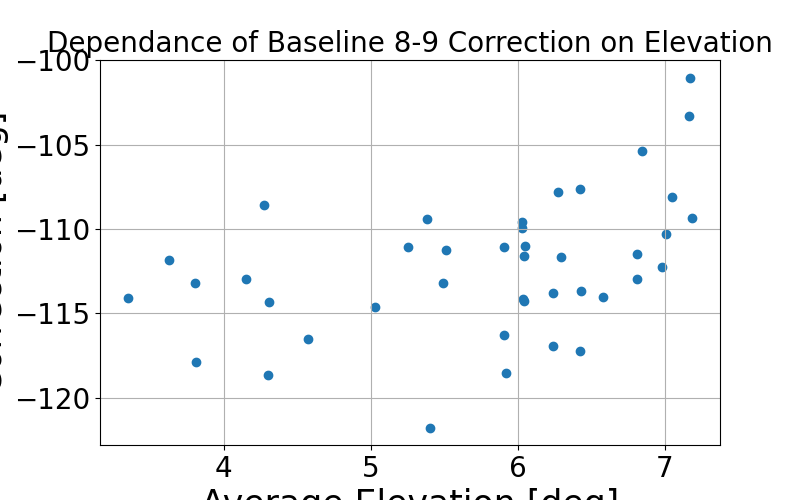

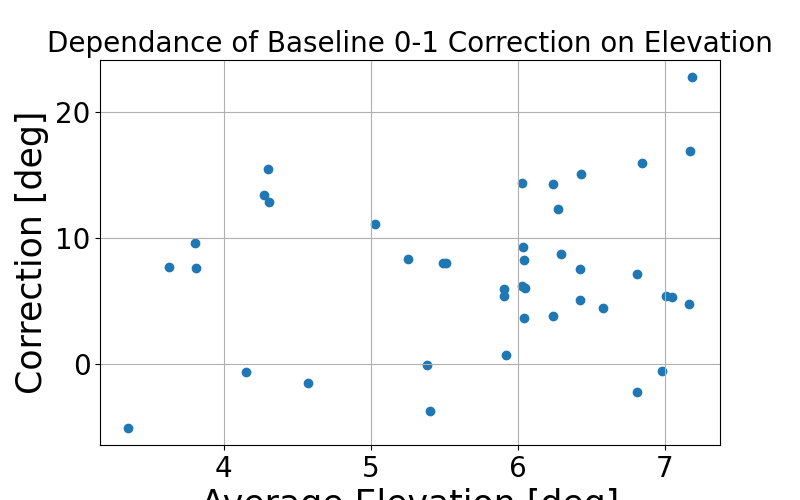

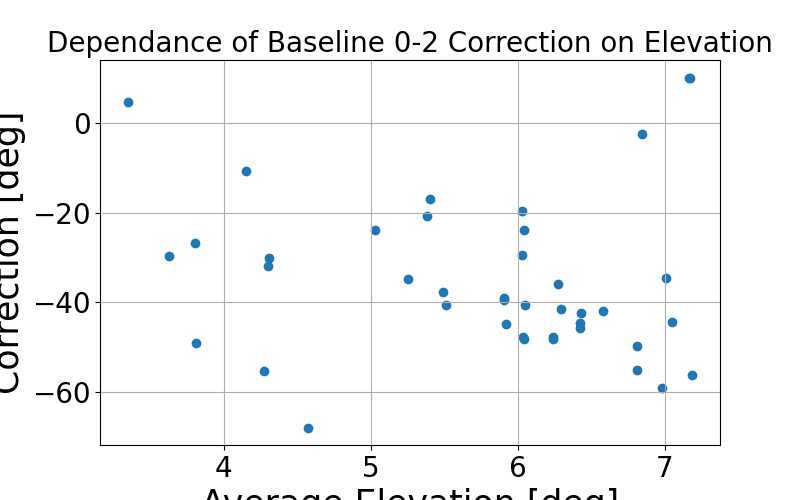

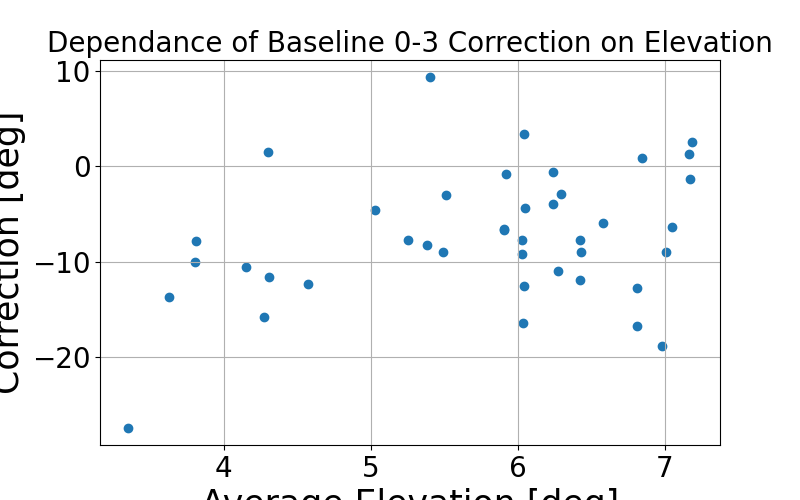

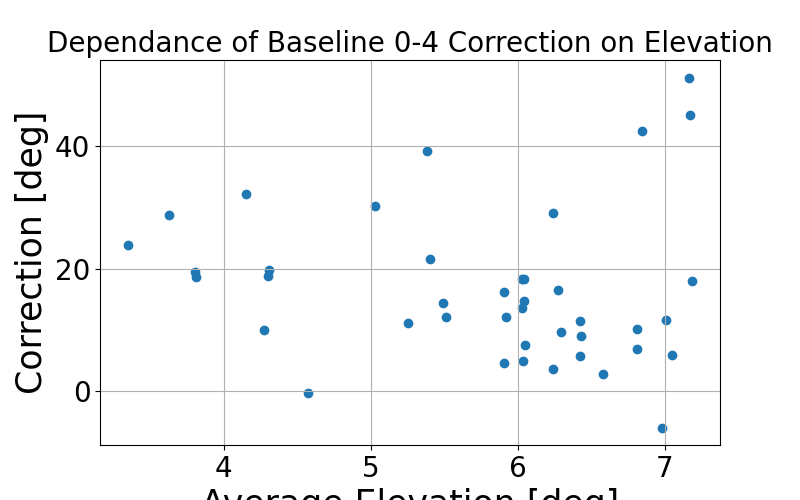

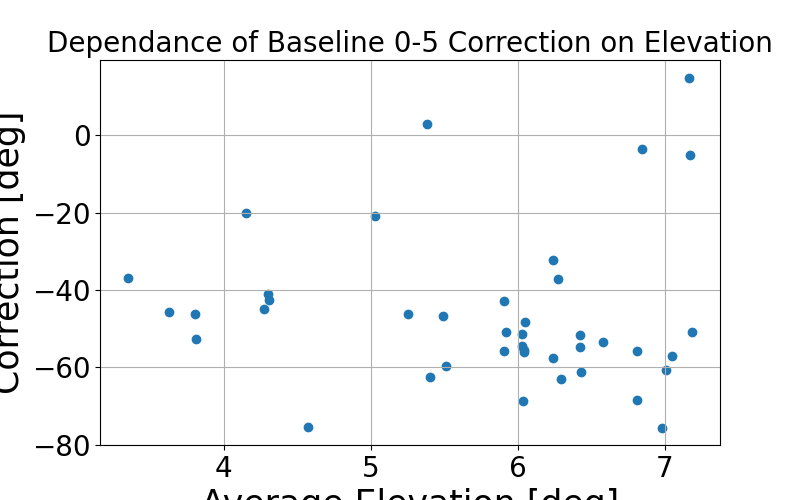

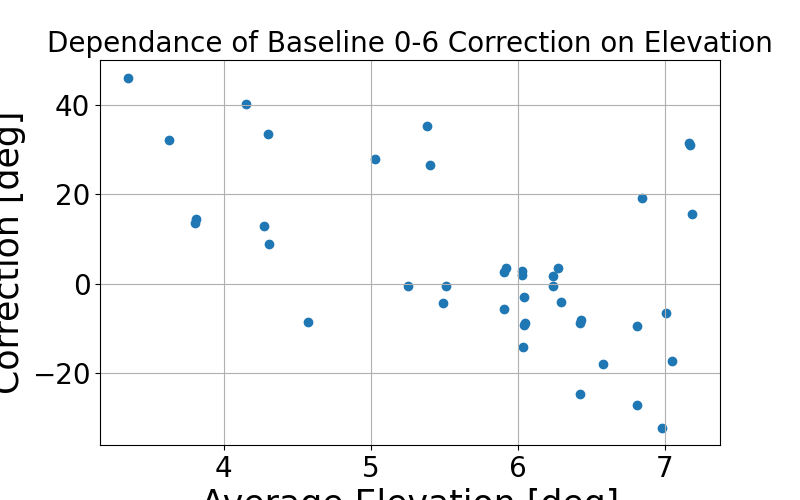

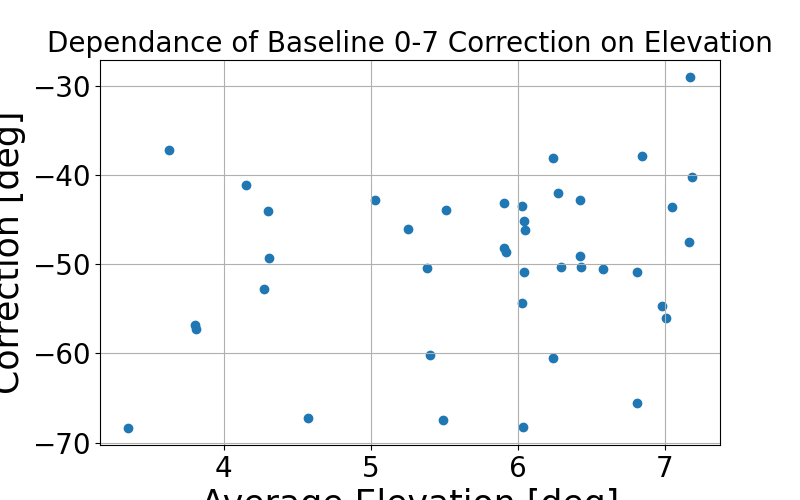

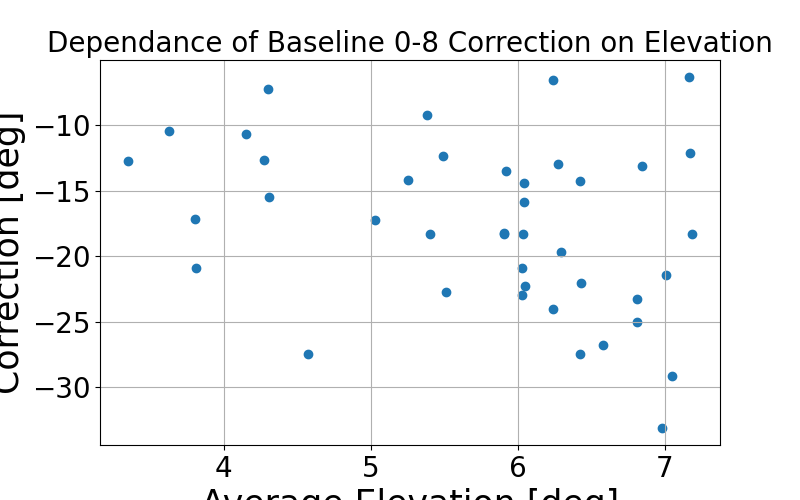

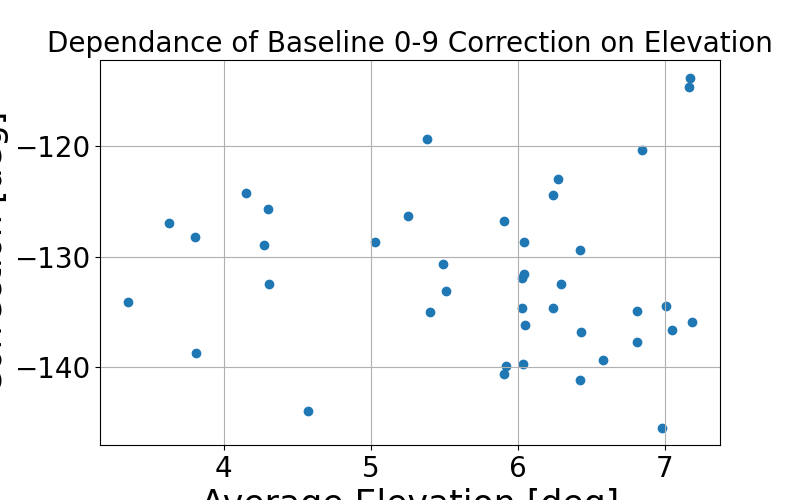

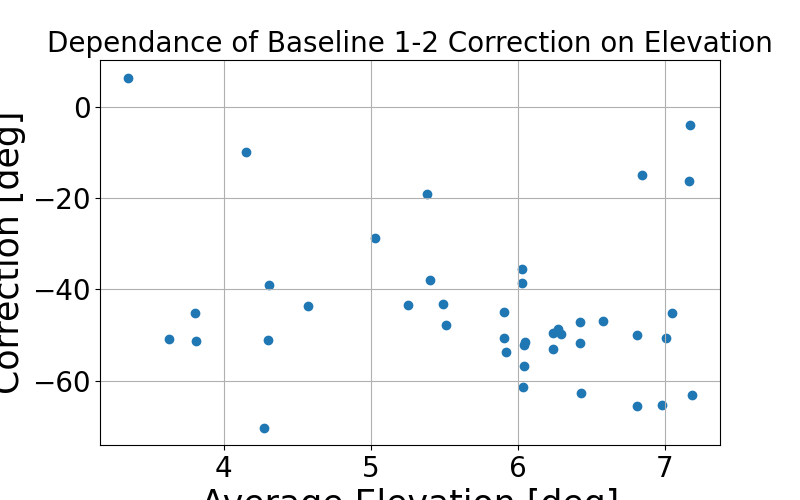

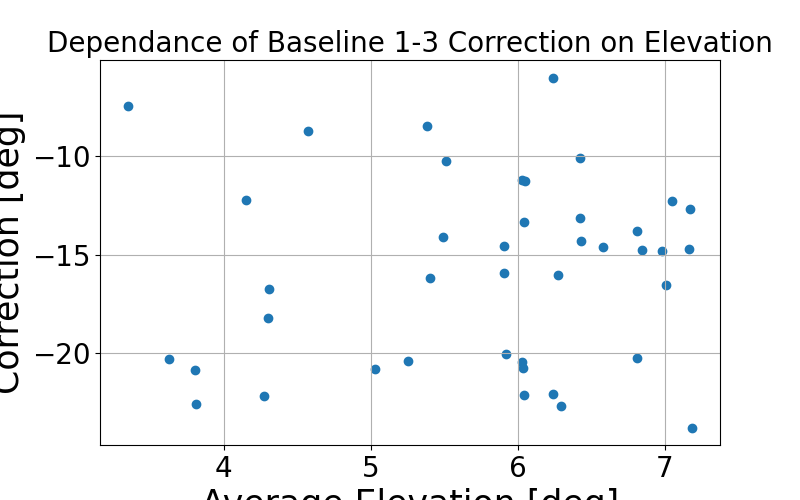

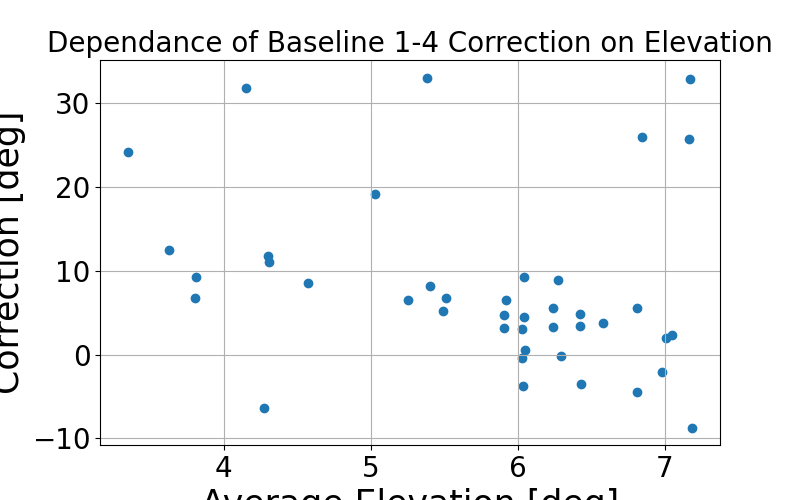

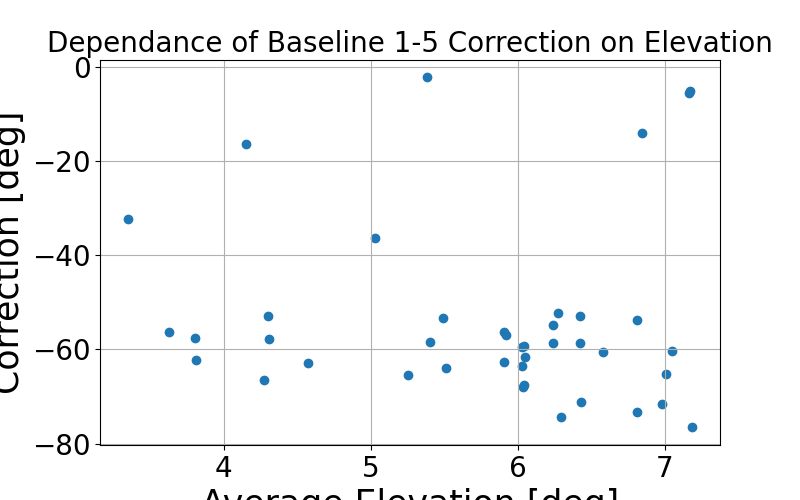

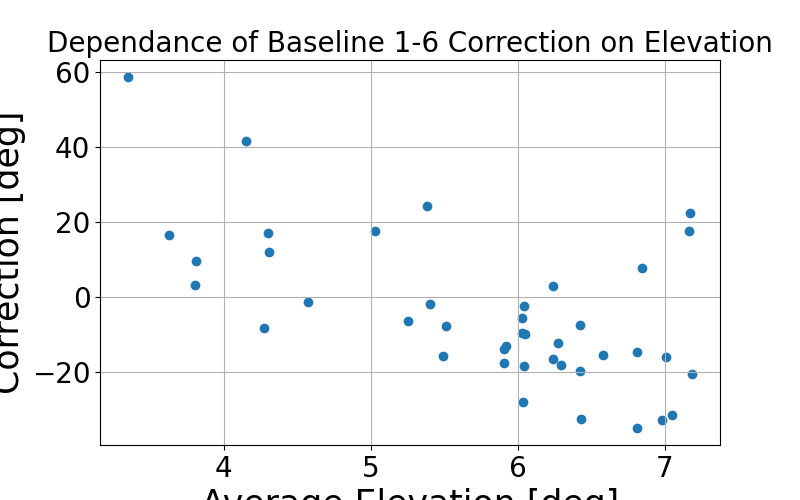

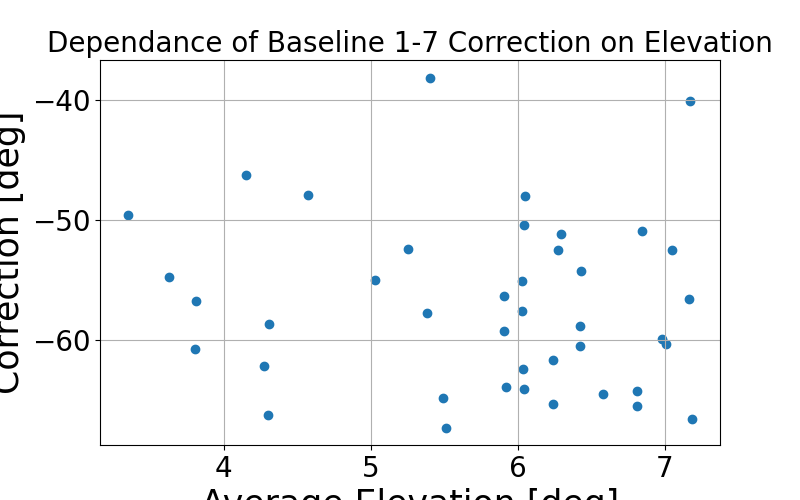

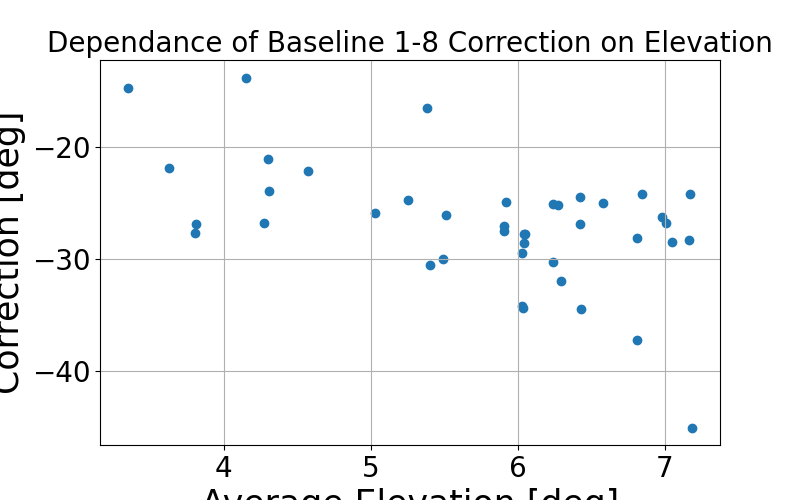

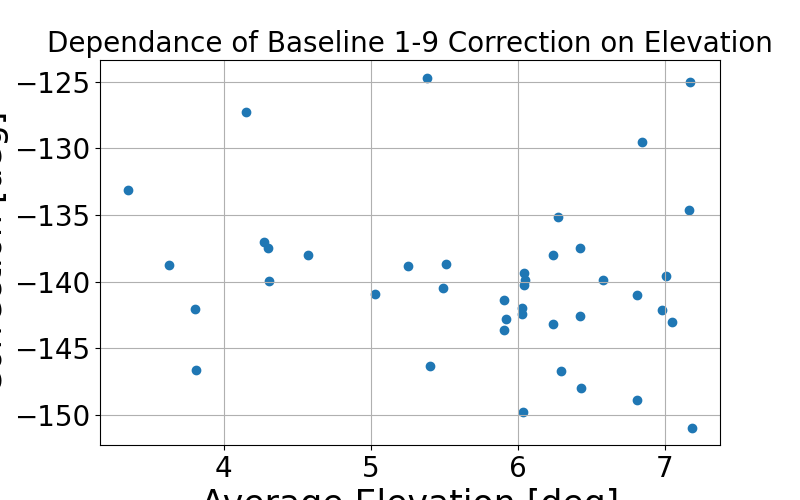

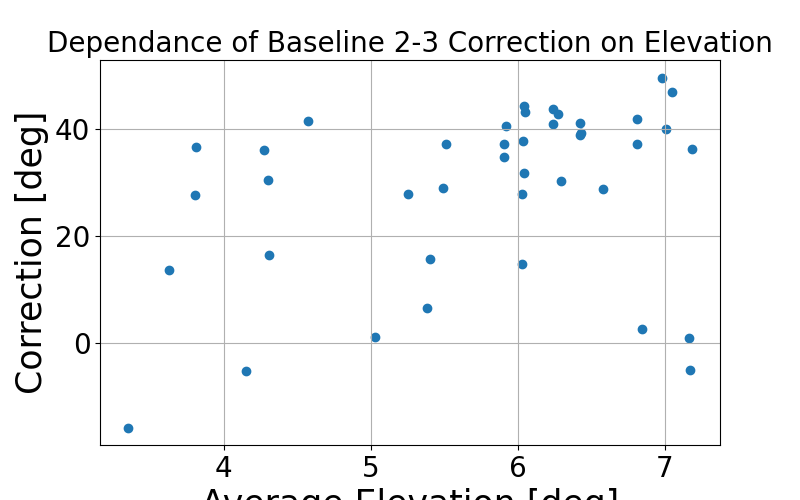

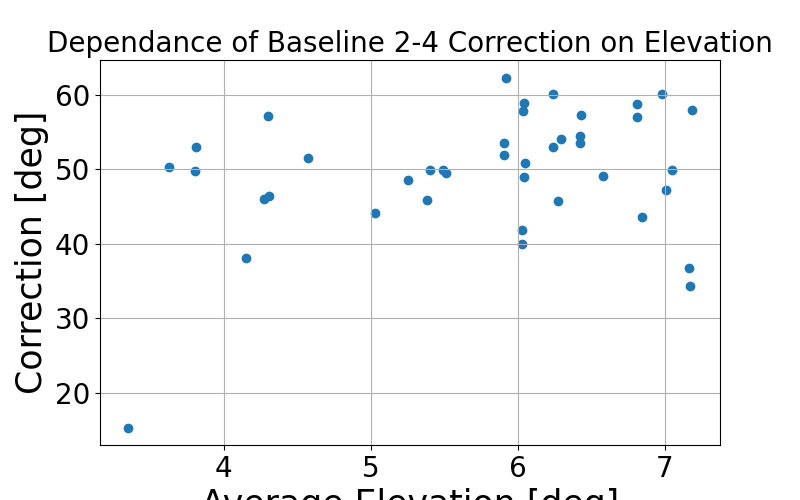

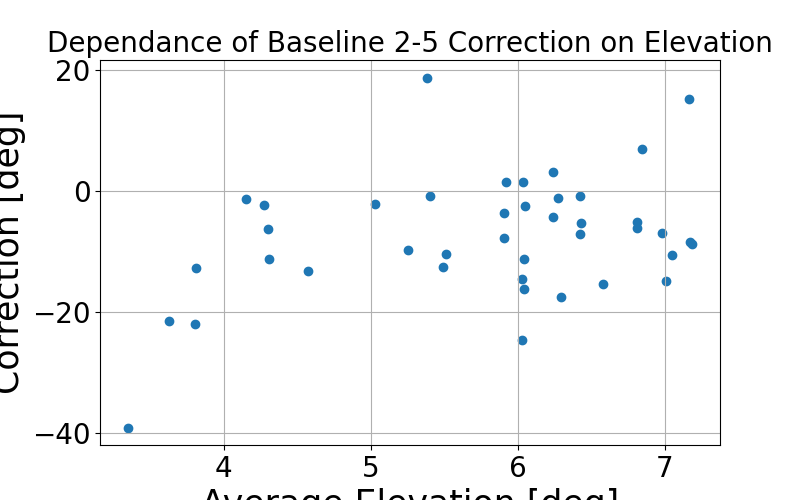

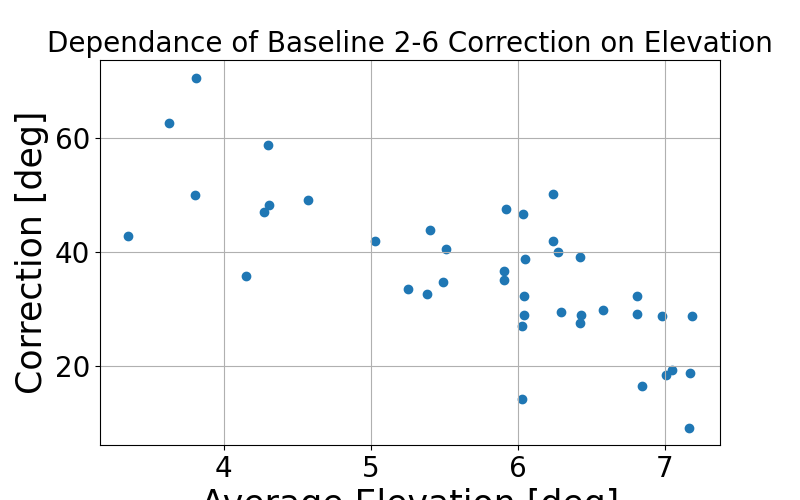

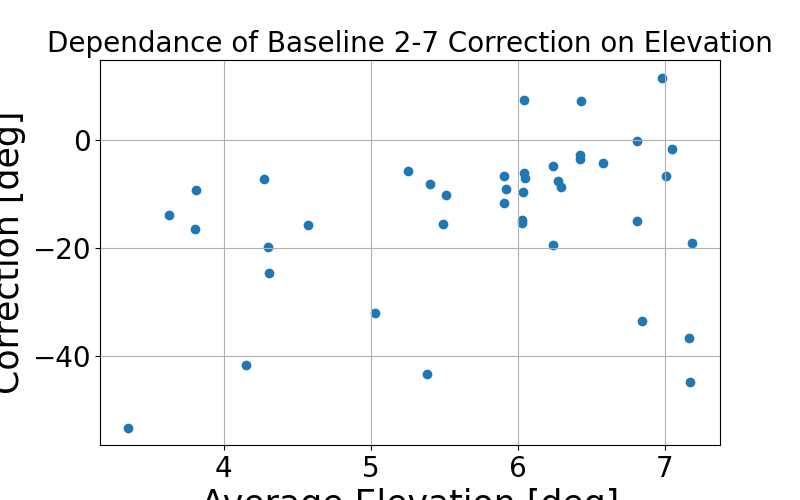

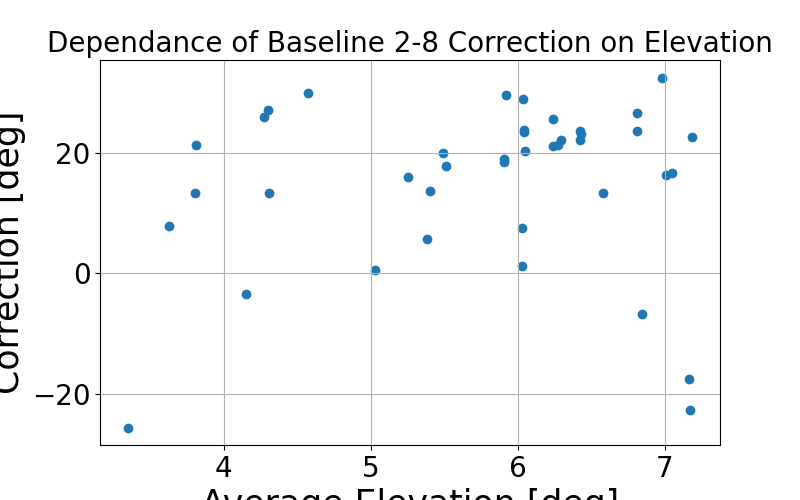

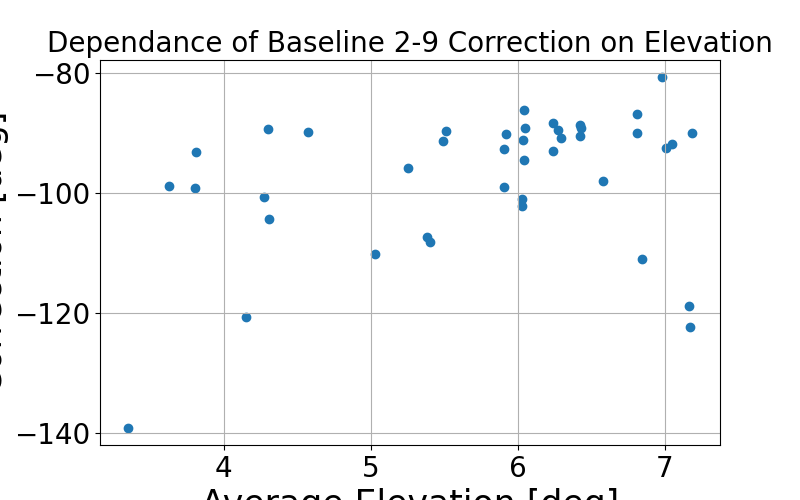

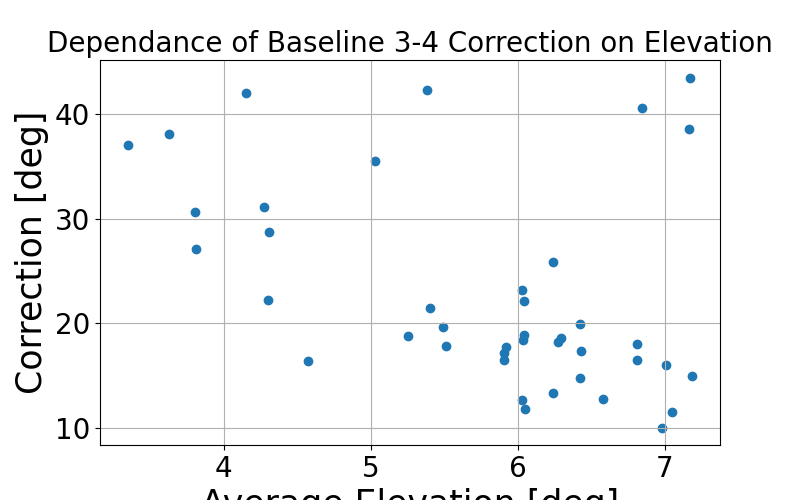

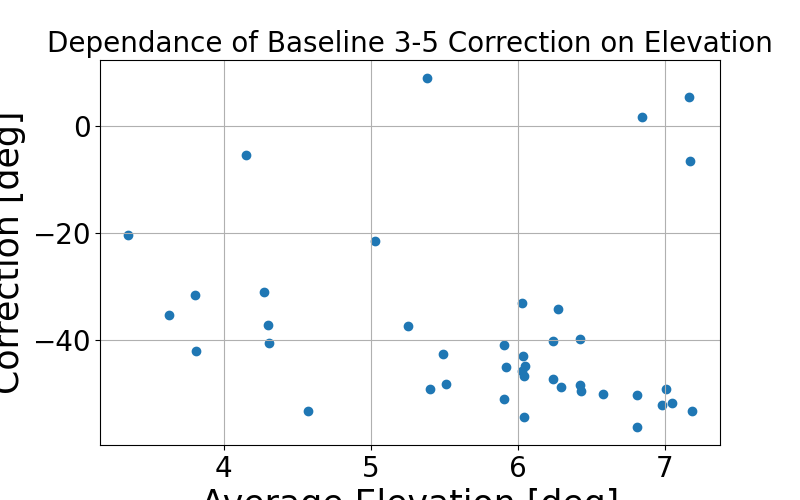

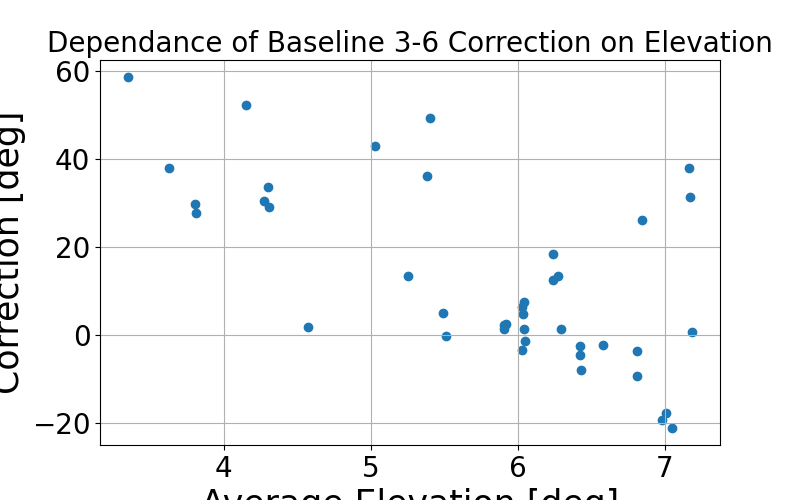

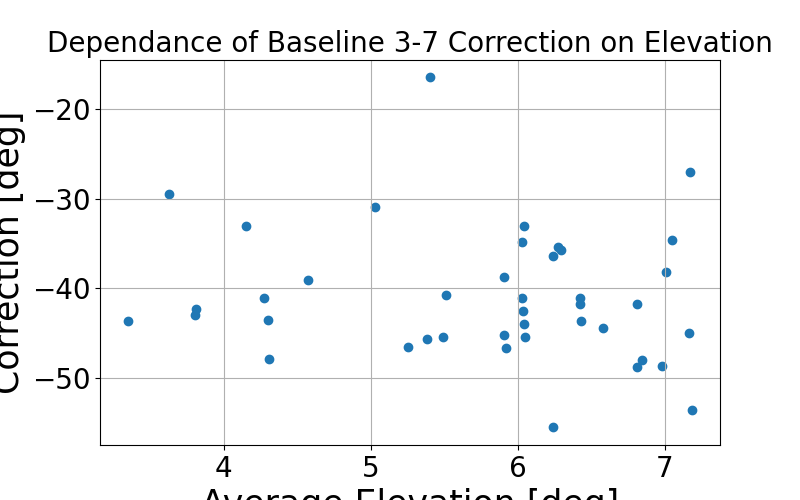

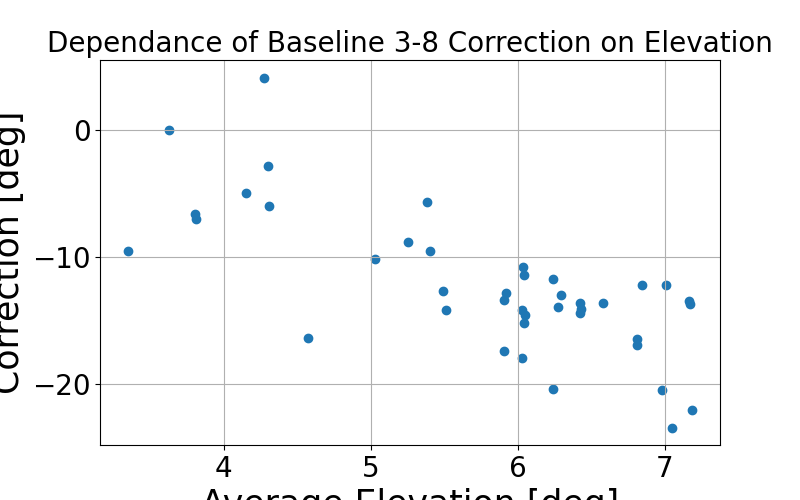

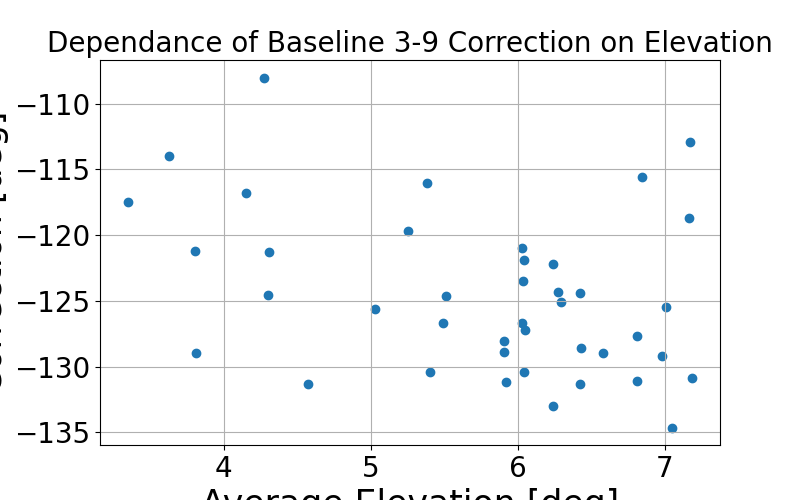

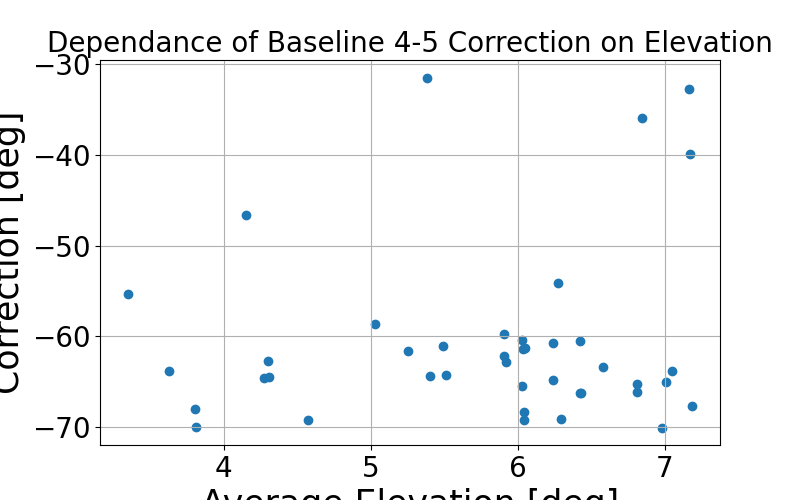

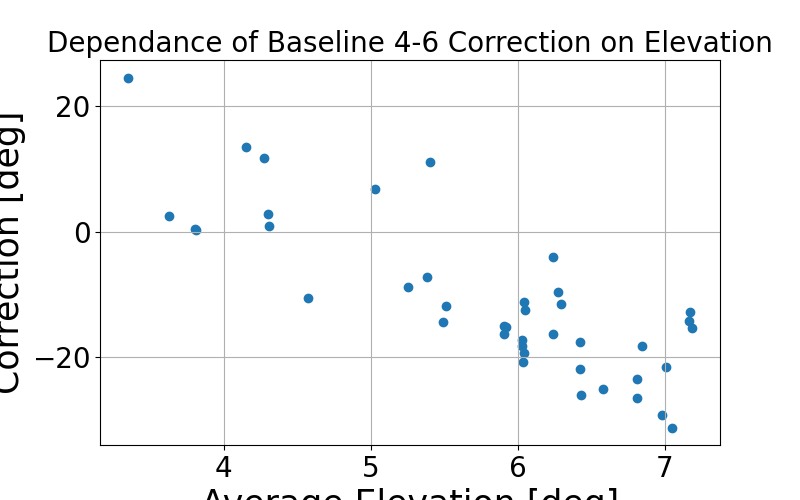

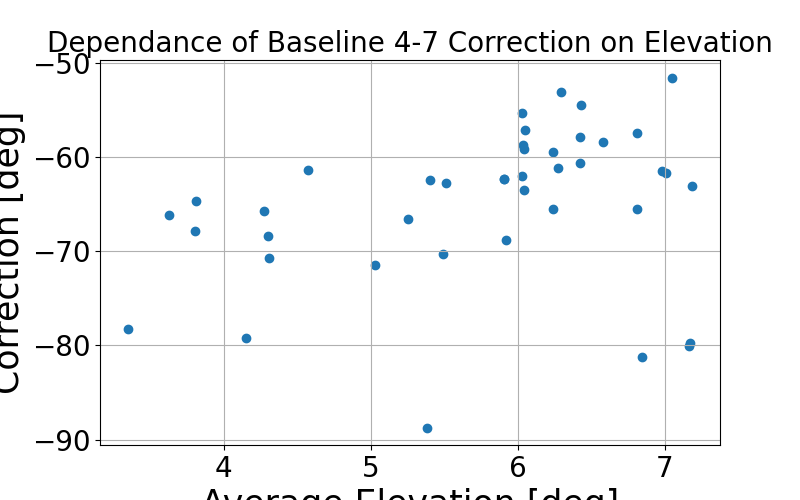

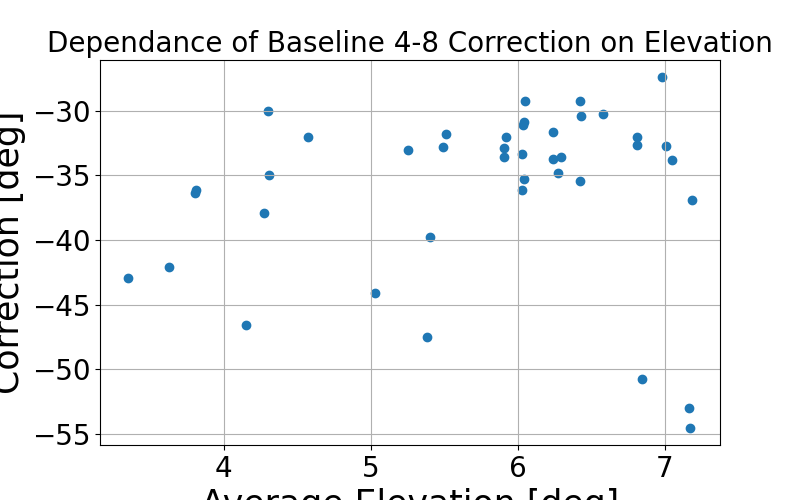

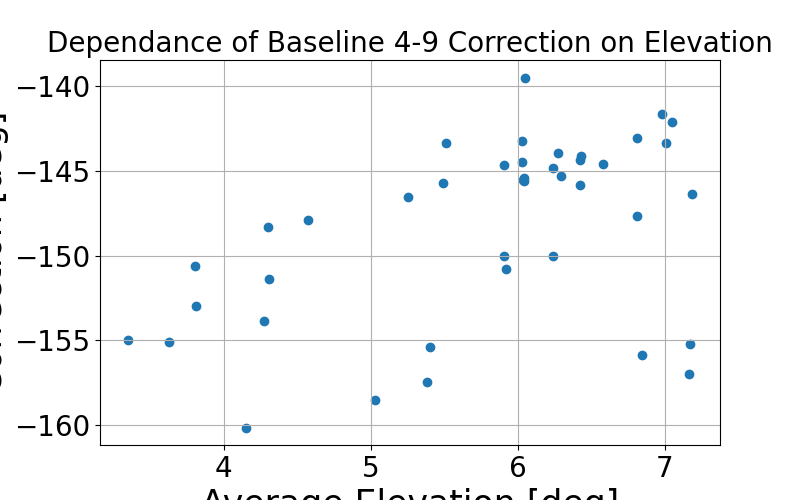

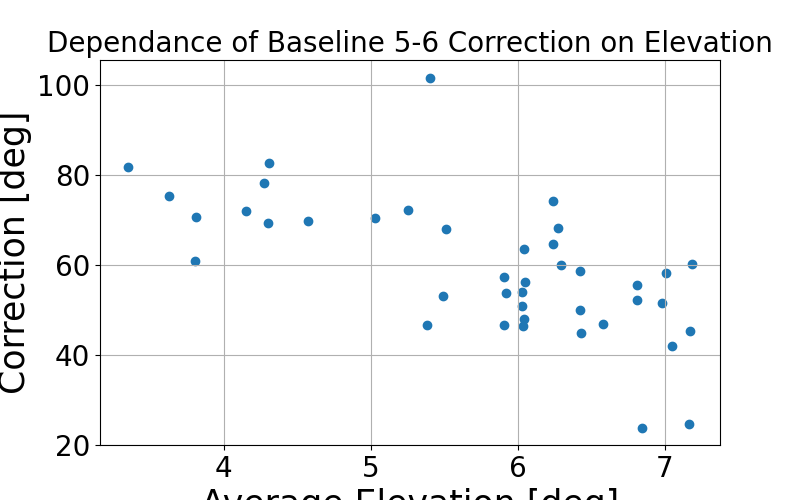

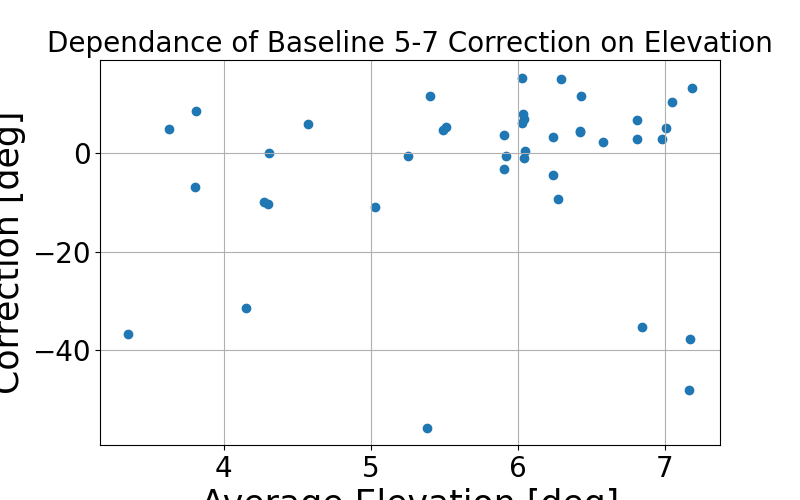

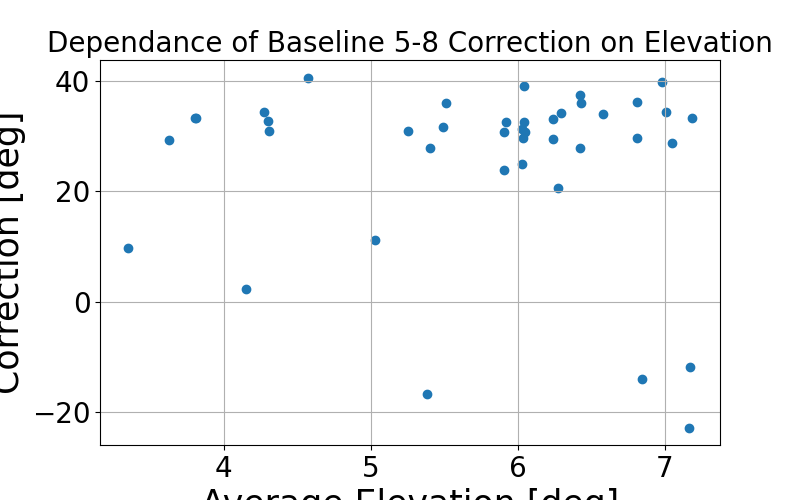

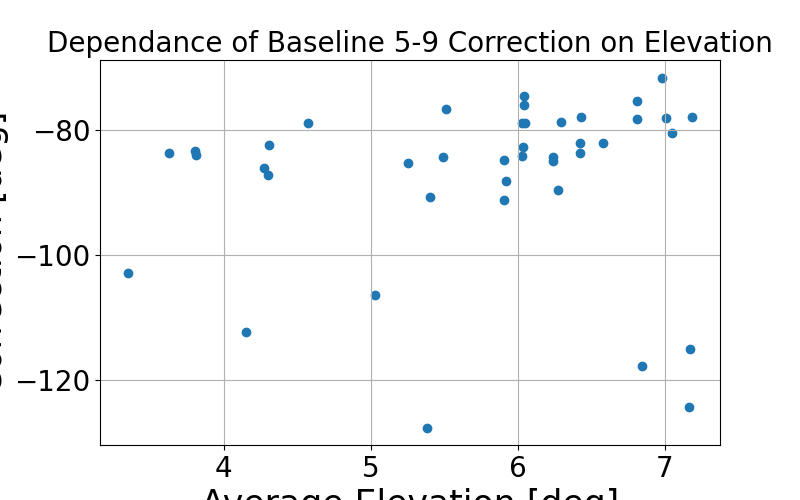

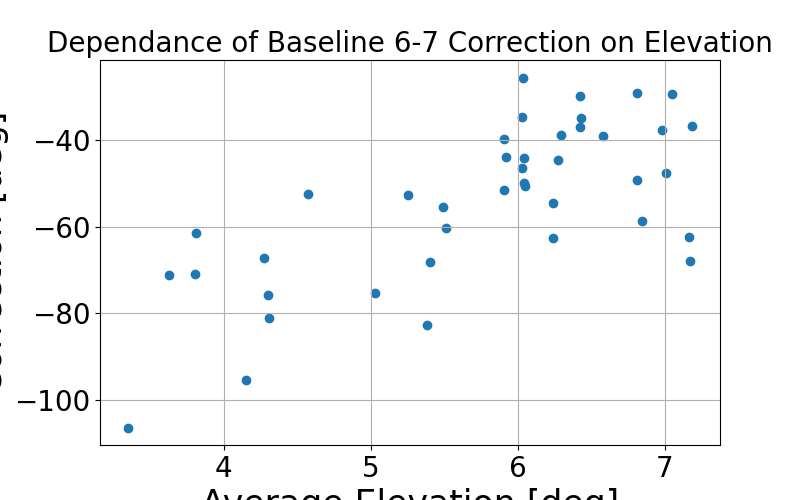

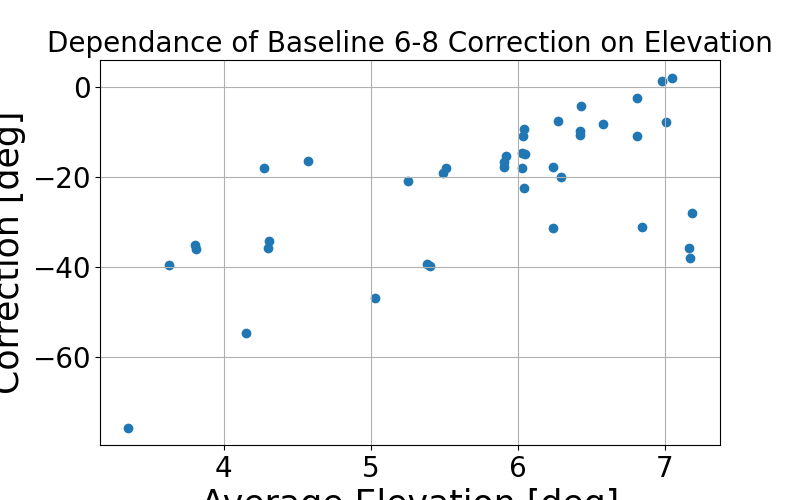

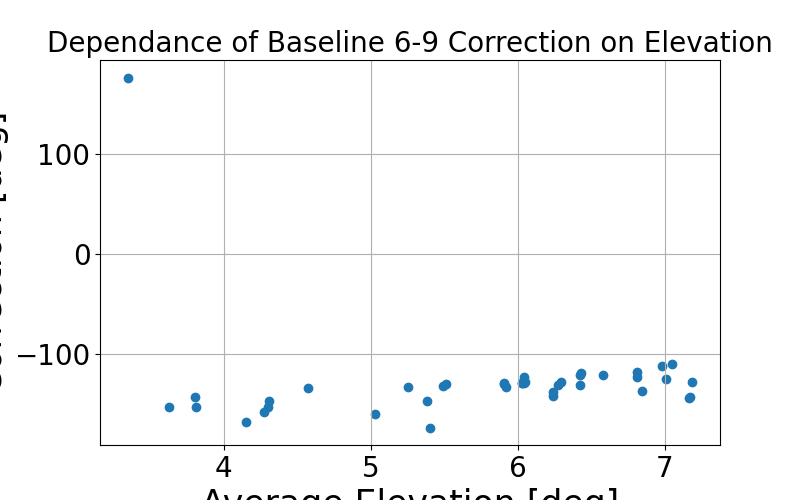

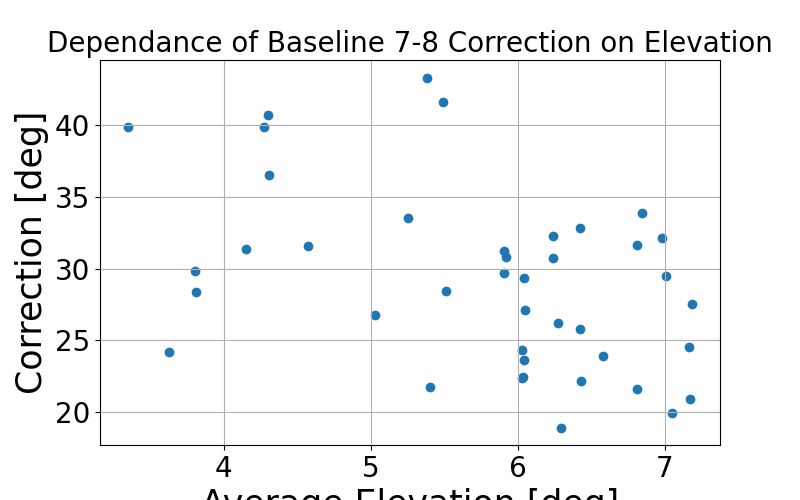

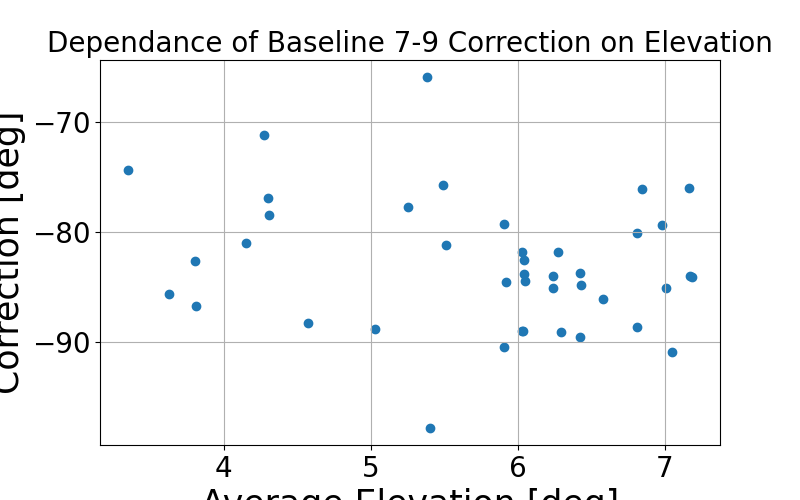

In [255]:
total_amplitudes = total_amplitudes_copy.copy()
total_phases = total_phases_copy.copy()
total_self_amps = total_self_amps_copy.copy()
total_elevations = total_elevations_copy.copy()
total_azimuths = total_azimuths_copy.copy()

plotting = False
n_corrections = total_phases.shape[0]
if plotting:
    fig, ax = plt.subplots()
    for plane in range(n_corrections):
        ax.scatter(np.arange(45), total_phases[plane, :]%360, c='tab:blue')

averaged_corrections = []
median_corrections = []
stdev_corrections = []

# calculate the mean/median etc. 
for baseline in range(45): # total_phases already has the planes selected from above
    median = ap.angular_median(np.deg2rad(total_phases[:, baseline]%360))
    mean, stdev = ap.angular_mean_and_stdev(np.deg2rad(total_phases[:, baseline]))
    averaged_corrections.append(np.rad2deg(mean))
    median_corrections.append(np.rad2deg(median))
    stdev_corrections.append(np.rad2deg(stdev))

averaged_corrections = np.array(averaged_corrections)
averaged_corrections[averaged_corrections < 0] += 360

median_corrections = np.array(median_corrections)
stdev_corrections = np.array(stdev_corrections)

if plotting:
    ax.scatter(np.arange(45), averaged_corrections, c='red', label='angular mean')
    ax.scatter(np.arange(45), median_corrections, c='yellow', label='angular median')
    ax.scatter(np.arange(45), stdev_corrections, c='green', label='angular standard dev')
    ax.legend()
    ax.set_title('Before Data Filter')
    ax.grid()
    plt.show()


# amplitude calibration
# the idea:
# the amplitude of a visibility, in general, may be low (or high) due to destructive interference from multiple targets in the sky.
# for an airplane, the overwhelming contribution to the visibility amplitude is KNOWN to be only the airplane.
# therefore, all visibility amplitudes should be "normalised" to an airplane, such that they are equal for the airplane.

# find the visibility with the best (tightest, not least shift) phase response
min_index = np.argmin(stdev_corrections)
baseline = 0
found = False
for i in range(10):
    for j in range(i+1, 10):
        if found:
            continue
        if baseline == min_index:
            found = True
            print(f'normalising amplitude to baseline {i}-{j}, index {min_index}')
        else:
            baseline += 1

# calculate the amplitude ratio between the best phase response baseline and the remaining baselines
median_amplitudes = np.median(total_amplitudes, axis=0)
amplitude_ratio = total_amplitudes / total_amplitudes[:, min_index][:, np.newaxis]
median_amplitude_ratios = np.median(amplitude_ratio, axis=0)

# calculate the amplitude ratio between the reference antenna (dealer's choice) and the remaining antennas
reference_antenna = 1
median_self_amps = np.median(total_self_amps, axis=0)
self_amp_ratio = total_self_amps / total_self_amps[:, reference_antenna][:, np.newaxis]
median_self_amp_ratios = np.median(self_amp_ratio, axis=0)

# sanitise the amplitude and phases: whenever all of the amplitude ratios are about 1, the phase gets completely incoherent.
# these airplanes shouldn't be included in any analysis, so remove them and repeat the process.
n_deleted = 0
for i in range(amplitude_ratio.shape[0]-1, -1, -1):
    if np.all(np.abs(amplitude_ratio[i, :] - 1) < 0.25):
        amplitude_ratio = np.delete(amplitude_ratio, (i), axis=0)
        self_amp_ratio = np.delete(self_amp_ratio, (i), axis=0)
        total_self_amps = np.delete(total_self_amps, (i), axis=0)
        total_phases = np.delete(total_phases, (i), axis=0)
        total_elevations = np.delete(total_elevations, (i), axis=0)
        total_azimuths = np.delete(total_azimuths, (i), axis=0)
        n_deleted += 1
        
print(f'deleted {n_deleted} nasty airplanes')

# re-calculate the mean/median etc.
averaged_corrections = []
median_corrections = []
stdev_corrections = []

for baseline in range(45): # total_phases already has the planes selected from above
    median = ap.angular_median(np.deg2rad(total_phases[:, baseline]%360))
    mean, stdev = ap.angular_mean_and_stdev(np.deg2rad(total_phases[:, baseline]))
    averaged_corrections.append(np.rad2deg(mean))
    median_corrections.append(np.rad2deg(median))
    stdev_corrections.append(np.rad2deg(stdev))

averaged_corrections = np.array(averaged_corrections)
averaged_corrections[averaged_corrections < 0] += 360

median_corrections = np.array(median_corrections)
stdev_corrections = np.array(stdev_corrections)

print(median_corrections)


# 3D coordinates of antennas
wavelength = 6.056
ant_coords = [  [0.,15.10,73.80,24.2,54.5,54.5,42.40,54.5,44.20,96.9], # x
            [0.,0.,-99.90,0.,-94.50,-205.90,-177.2,0.,-27.30,0.],  # y
            [0.,0.0895,0.3474,0.2181,0.6834,-0.0587,-1.0668,-0.7540,-0.5266,-0.4087]] # z


"""
fig, ax = plt.subplots()
fig.set_size_inches(fig_width_inches, fig_height_inches)
ax.set_ylabel('Correction [deg]')
ax.set_xlabel('Baseline Length [m]')
ax.set_title(f'Dependance of Baseline {antenna1}-{antenna2} Correction on Length')
ax.grid()
"""

baseline = 0
for antenna1 in range(10):
    for antenna2 in range(antenna1+1, 10):
        
        fig, ax = plt.subplots()
        fig.set_size_inches(fig_width_inches, fig_height_inches)
        ax.set_ylabel('Correction [deg]')
        ax.set_xlabel('Average Elevation [deg]')
        ax.set_title(f'Dependance of Baseline {antenna1}-{antenna2} Correction on Elevation')
        ax.grid()
        ax.scatter(total_elevations, total_phases[:, baseline])
        
    
        # coordinates of antennas 1 and 2
        a1 = np.array([ant_coords[0][antenna1], ant_coords[1][antenna1], ant_coords[2][antenna1]])
        a2 = np.array([ant_coords[0][antenna2], ant_coords[1][antenna2], ant_coords[2][antenna2]])
    
        # baseline vector
        d = a2 - a1

        baseline += 1
        
plt.show()    

In [258]:
# generate antenna based calibrations

# sum the standard deviations of phase corrections for each antenna. take the smallest number as the "best" antenna
sum_stdev = np.zeros(10)
baseline = 0
for antenna1 in range(10):
    for antenna2 in range(antenna1+1, 10):
        sum_stdev[antenna1] += stdev_corrections[baseline]
        sum_stdev[antenna2] += stdev_corrections[baseline]
        baseline += 1
        
best_antenna = np.argmin(sum_stdev)
print(f'best antenna = {best_antenna}')

# use the star pattern from the best antenna:
antenna_phase_corrections = np.zeros(10)
antenna_phase_corrections[best_antenna] = 0

antenna_amp_corrections = 1 / median_self_amp_ratios

baseline = 0
for antenna1 in range(10):
    for antenna2 in range(antenna1+1, 10):
        if antenna1 == best_antenna:
            antenna_phase_corrections[antenna2] = -median_corrections[baseline]
        elif antenna2 == best_antenna:
            antenna_phase_corrections[antenna1] = median_corrections[baseline]
        baseline += 1

print(antenna_phase_corrections)
print(antenna_amp_corrections)

antenna_based_vis_corr = np.zeros(45)
antenna_based_amp_corr = np.zeros(45)
baseline = 0
for antenna1 in range(10):
    for antenna2 in range(antenna1+1, 10):
        antenna_based_vis_corr[baseline] = antenna_phase_corrections[antenna1] - antenna_phase_corrections[antenna2]
        antenna_based_amp_corr[baseline] = antenna_amp_corrections[antenna1] * antenna_amp_corrections[antenna2]
        baseline += 1

best antenna = 9
[227.50861134 219.71808251 267.43029972 234.52880367 213.63513527
 276.33166311 228.19685695 275.99295713 247.7561886    0.        ]
[0.9024817  1.         0.936088   0.4049209  0.8223989  1.2241687
 1.2376907  0.43977898 0.48407224 0.6760221 ]


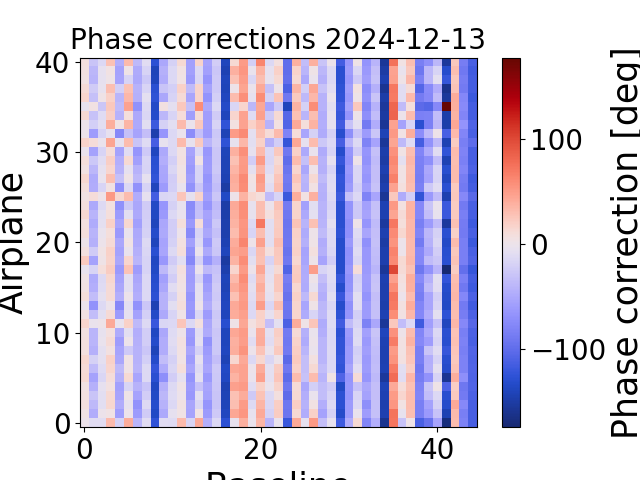

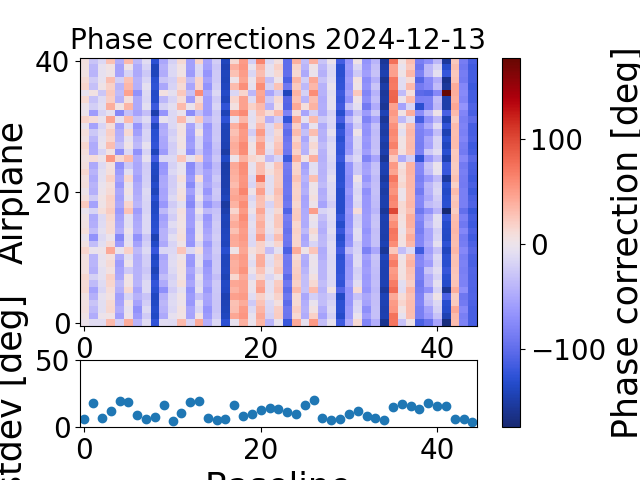

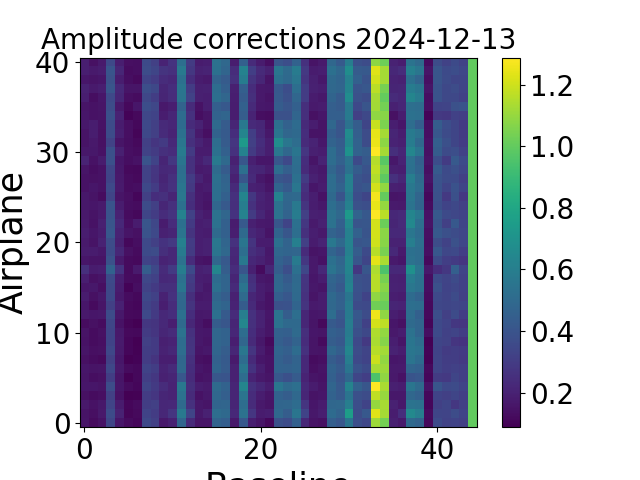

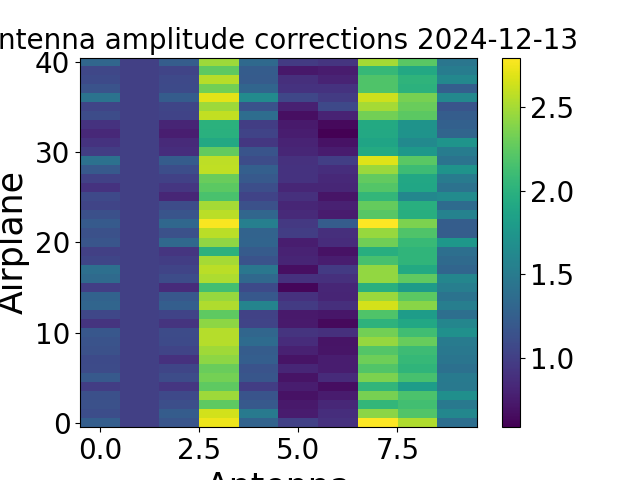

In [259]:
# compare results of visibility-based corrections to antenna-based corrections
# or use the commmented lines to just examine visibility calibrations on their own.

# phase correction
fig, ax = plt.subplots()
total_phases_rejigged = total_phases%360
total_phases_rejigged[total_phases_rejigged > 180] -= 360 

#cmap = ax.imshow((total_phases - antenna_based_vis_corr)%360 , origin='lower', aspect='auto', cmap=plt.get_cmap("cet_cyclic_wrkbw_10_90_c43"))
cmap = ax.imshow(total_phases_rejigged, origin='lower', aspect='auto', cmap=plt.get_cmap("cet_diverging_bwr_20_95_c54")) # cmap=plt.get_cmap("cet_cyclic_wrkbw_10_90_c43")
ax.set_xlabel('Baseline')
ax.set_ylabel('Airplane')
ax.set_title(f'Phase corrections {year:04d}-{month:02d}-{day:02d}')# - antenna corrections')
fig.colorbar(cmap, label='Phase correction [deg]')
plt.show(fig)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios':[4,1]})
cmap = ax[0].imshow(total_phases_rejigged, origin='lower', aspect='auto', cmap=plt.get_cmap("cet_diverging_bwr_20_95_c54")) # cmap=plt.get_cmap("cet_cyclic_wrkbw_10_90_c43")
ax[0].set_ylabel('Airplane')
ax[0].set_title(f'Phase corrections {year:04d}-{month:02d}-{day:02d}')# - antenna corrections')
fig.colorbar(cmap, ax=ax, label='Phase correction [deg]')
ax[1].scatter(np.arange(45), stdev_corrections)
ax[1].set_xlim([-0.5, 44.5])
ax[1].set_xlabel('Baseline')
ax[1].set_ylim([0, 50])
ax[1].set_ylabel('stdev [deg]')
plt.show(fig)

# amplitude correction
fig, ax = plt.subplots()
#cmap = ax.imshow(amplitude_ratio - 1 / antenna_based_amp_corr, origin='lower', aspect='auto')
cmap = ax.imshow(amplitude_ratio, origin='lower', aspect='auto')
ax.set_xlabel('Baseline')
ax.set_ylabel('Airplane')
ax.set_title(f'Amplitude corrections {year:04d}-{month:02d}-{day:02d}')
fig.colorbar(cmap, ax=ax)
plt.show(fig)

# self-spectra amplitudes
fig, ax = plt.subplots()
cmap = ax.imshow(self_amp_ratio, origin='lower', aspect='auto')
ax.set_xlabel('Antenna')
ax.set_ylabel('Airplane')
ax.set_title(f'Antenna amplitude corrections {year:04d}-{month:02d}-{day:02d}')
fig.colorbar(cmap, ax=ax)
plt.show(fig)

In [ ]:
modifier = '_'

# save the phase corrections
np.save(f'median_corrections{modifier}{year:04d}-{month:02d}-{day:02d}.npy', median_corrections)

# save full complex corrections
complex_corrections = (1 / np.mean(amplitude_ratio, axis=0)) * np.exp(-1j * np.deg2rad(median_corrections))
np.save(f'complex_corrections{modifier}{year:04d}-{month:02d}-{day:02d}.npy', complex_corrections)

#np.savetxt("complex_corrections_2024-09-20.csv", complex_corrections, delimiter=",")

In [ ]:
# Level 2 data will now have to be processed before continuing

In [ ]:
# inputs to the second part of the script:
# level2_files - the result of processing the uncalibrated level 1 data to level 2 data using the baseline calibrations
#                found in the previous cell. 
level2_files = []
#level2_files.append(f'/mnt/NAS/airplane-data/L2_1/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # without relaxation

#level2_files.append(f'/mnt/NAS/airplane-data/L2-Scal/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated
level2_files.append(f'/mnt/NAS/airplane-data/L2-standardcal/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated
#level2_files.append(f'/mnt/NAS/airplane-data/L2-no-cal/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated
#level2_files.append(f'/mnt/NAS/airplane-data/L2-manual-cal/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated
#level2_files.append(f'/mnt/NAS/airplane-data/L2-new-coeffs-with-cal-and-pos-azimuth-median_1/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated

#level2_files.append(f'/mnt/NAS/airplane-data/L2-median-calibrated/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated


In [ ]:
# plot up the level 2 data and the corresponding airplane data
fig_az, ax_az = plt.subplots()
fig_az.set_size_inches(fig_width_inches, fig_height_inches)
ax_az.set_ylabel('Azimuth [deg]')
ax_az.set_xlabel('Time')
ax_az.set_title(f'Azimuth')
ax_az.xaxis.set_major_locator(locator)
ax_az.xaxis.set_major_formatter(formatter)

fig_el, ax_el = plt.subplots()
fig_el.set_size_inches(fig_width_inches, fig_height_inches)
ax_el.set_ylabel('Elevation [deg]')
ax_el.set_xlabel('Time')
ax_el.set_title(f'Elevation')
ax_el.xaxis.set_major_locator(locator)
ax_el.xaxis.set_major_formatter(formatter)

fig_azel, ax_azel = plt.subplots()
fig_azel.set_size_inches(fig_width_inches, fig_height_inches)
ax_azel.set_ylabel('Elevation [deg]')
ax_azel.set_xlabel('Azimuth [deg]')
ax_azel.set_title(f'Azimuth/Elevation')
# plot the allowed az/el polygon (wrt boresight)
az = np.load('allowed_airplane_azimuth.npy')
az = np.where(az > 180.0, az - 360.0, az)
el = np.load('allowed_airplane_elevation.npy')
ax_azel.scatter(az, el, c='red')
ax_azel.legend(['allowed airplane AoAs'])

fig_els, ax_els = plt.subplots()
fig_els.set_size_inches(fig_width_inches, fig_height_inches)
ax_els.set_ylabel('True Elevation [deg]')
ax_els.set_xlabel('Measured Elevation - True Elevation [deg]')
ax_els.set_title(f'Error in Elevation')

for file in level2_files:
    print(file)
    try:
        f = h5py.File(file)
    except Exception as e:
        print(f'Excepted {e}\nContinuing...')
        continue
    altitude = f['data']['altitude'][:]
    azimuth = f['data']['azimuth'][:]
    doppler_shift = f['data']['doppler_shift'][:]
    elevation = f['data']['elevation'][:]
    latitude = f['data']['latitude'][:]
    longitude = f['data']['longitude'][:]
    rf_distance = f['data']['rf_distance'][:]
    slant_range = f['data']['slant_range'][:]
    snr_db = f['data']['snr_db'][:]
    time = f['data']['time'][:]
    utc_time = vutcfromtimestamp(time)

    #range_filter = (rf_distance < 256) & (rf_distance > 246)
    #else:
    #range_filter = (rf_distance < 301) & (rf_distance > 291)
    range_filter = (rf_distance < 301) & (rf_distance > 246)
        
    # plot az and el / time
    ax_az.scatter(utc_time[range_filter], azimuth[range_filter])
    ax_el.scatter(utc_time[range_filter], elevation[range_filter])
    
    # plot az/el
    ax_azel.scatter(azimuth[range_filter], elevation[range_filter])
    
    f.close()

aircrafts_dbs = ap.load_airplane_data(f'aircrafts_dbs_{year:04d}-{month:02d}-{day:02d}.pckl')
plane_indices = [1,3,9,12,16,34,53,67,106,109,123,127,132,139,141,143,150,152,182] # 12/12/2020
plane_indices = []
airplane_idx = 0

el_difference = []
true_el = []
for db in aircrafts_dbs:
    # db is a database of every airplane in the timeframe.
    if db == None:
        continue
        
    # db[i].data.long/lat is the time series of data for one airplane (i)
    
    for i in range(len(db)): # db[i] is a single airplane in the timeframe.

        if airplane_idx not in plane_indices:
            plane_indices.append(airplane_idx)
            airplane_idx += 1
            #continue

        # indexes in db continue multiple airplanes, so need to manually find the indices for this airplane
        start_idx = db[i].data.index[0]
        end_idx = db[i].data.index[-1]

        # using the indexes, find the start and end times of the airplane
        ti = db[i].data.timestamp[start_idx]
        ti = ti.replace(tzinfo=None)
        tf = db[i].data.timestamp[end_idx]
        tf = tf.replace(tzinfo=None)

        
        # from the airplane's geographic latitude/longitude/altitude, find the azimuth/elevation/altitude of the airplane from the receiver
        # this azimuth is measured EAST OF NORTH
        az, el, slant_range = ap.find_aer_from_receiver(db[i].data.latitude, db[i].data.longitude, db[i].data.altitude * FT_TO_M)
        # still east of north, but adjusted to be -180 to 180 instead of 0 to 360
        az = np.where(az > 180.0, az - 360.0, az)

        this_airplane_db_time = db[i].data.timestamp[:] # .to_pydatetime().replace(tzinfo=timezone.utc)

        # level 2 data filtered by time
        for k in range(this_airplane_db_time.shape[0]):
            index = this_airplane_db_time.index[k]
            l2_el = elevation[utc_time == this_airplane_db_time[index].to_pydatetime().replace(tzinfo=None)]
            el_difference.append(l2_el - el[index])
            for m in range(l2_el.shape[0]):
                true_el.append(el[index])
            
        # plot az and el
        ax_el.scatter(this_airplane_db_time, el, c='black')
        ax_az.scatter(this_airplane_db_time, az, c='black')
        ax_azel.scatter(az, el, c='black')

        airplane_idx += 1

true_el = np.hstack(true_el)
el_difference = np.hstack(el_difference)

#ax_els.hist(el_difference, bins=[-6+i*0.2 for i in range(50)])
ax_els.scatter(el_difference, true_el)

plt.show()


In [ ]:
# perform manual geolocation of the echoes using AoA
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

fig_ll, ax_ll = plt.subplots()
fig_ll.set_size_inches(fig_width_inches, fig_height_inches)
ax_ll.set_ylabel('Latitude [deg]')
ax_ll.set_xlabel('Longitude [deg]')
ax_ll.set_title(f'Airplane tracks and ICEBEAR echoes - {year:04}-{month:02d}-{day:02d}')
stoon_airport = [52.17145, -106.70039]
icebear_rx = [52.24393, -106.45025]
icebear_tx = [50.89335, -109.40317]
ax_ll.scatter(stoon_airport[1], stoon_airport[0], marker='*', c='black', s=70)
ax_ll.scatter(icebear_rx[1], icebear_rx[0], marker='*', c='r', s=70)
ax_ll.scatter(icebear_tx[1], icebear_tx[0], marker='*', c='b', s=70)
#ax_ll.set_xlim([-109.8, -105.8])
#ax_ll.set_ylim([50, 53])
ax_ll.legend(['Saskatoon Airport','ICEBEAR Rx','ICEBEAR Tx'])

fig_alt, ax_alt = plt.subplots()
fig_alt.set_size_inches(fig_width_inches, fig_height_inches)
ax_alt.set_ylabel('Altitude [km]')
ax_alt.set_xlabel('Time')
ax_alt.set_title(f'Altitude vs. Time - {year:04}-{month:02d}-{day:02d}')
#ax_lon_alt.xaxis.set_major_locator(locator)
#ax_lon_alt.xaxis.set_major_formatter(formatter)

fig_el, ax_el = plt.subplots()
fig_el.set_size_inches(fig_width_inches, fig_height_inches)
ax_el.set_ylabel('Elevation [deg]')
ax_el.set_xlabel('Time')
ax_el.set_title(f'Elevation vs. Time - {year:04}-{month:02d}-{day:02d}')
ax_el.xaxis.set_major_locator(locator)
ax_el.xaxis.set_major_formatter(formatter)

fig_lon_alt, ax_lon_alt = plt.subplots()
fig_lon_alt.set_size_inches(fig_width_inches, fig_height_inches)
ax_lon_alt.set_ylabel('Altitude [km]')
ax_lon_alt.set_xlabel('Longitude [deg]')
ax_lon_alt.set_title(f'Altitude vs. Longitude - {year:04}-{month:02d}-{day:02d}')
#ax_lon_alt.xaxis.set_major_locator(locator)
#ax_lon_alt.xaxis.set_major_formatter(formatter)

fig_lon_el, ax_lon_el = plt.subplots()
fig_lon_el.set_size_inches(fig_width_inches, fig_height_inches)
ax_lon_el.set_ylabel('Elevation [deg]')
ax_lon_el.set_xlabel('Longitude [deg]')
ax_lon_el.set_title(f'Elevation vs. Longitude - {year:04}-{month:02d}-{day:02d}')
#ax_lon_el.xaxis.set_major_locator(locator)
#ax_lon_el.xaxis.set_major_formatter(formatter)

fig_errel, ax_errel = plt.subplots()
fig_errel.set_size_inches(fig_width_inches, fig_height_inches)
ax_errel.set_ylabel('Error in Elevation [deg]')
ax_errel.set_xlabel('Azimuth [deg]')
ax_errel.set_title(f'Error in Elevation vs. Radar Azimuth - {year:04}-{month:02d}-{day:02d}')
#ax_lon_el.xaxis.set_major_locator(locator)
#ax_lon_el.xaxis.set_major_formatter(formatter)

for file in level2_files:
    print(file)
    try:
        f = h5py.File(file)
    except Exception as e:
        print(f'Excepted {e}\nContinuing...')
        continue
    altitude = f['data']['altitude'][:]
    azimuth = f['data']['azimuth'][:]
    doppler_shift = f['data']['doppler_shift'][:]
    elevation = f['data']['elevation'][:]
    latitude = f['data']['latitude'][:]
    longitude = f['data']['longitude'][:]
    rf_distance = f['data']['rf_distance'][:]
    slant_range = f['data']['slant_range'][:]
    snr_db = f['data']['snr_db'][:]
    time = f['data']['time'][:]
    utc_time = vutcfromtimestamp(time)
    echo_timestamps = ap.datetime_to_seconds_since_epoch(utc_time)
    

    range_filter = (rf_distance < 256) & (rf_distance > 246)
    #range_filter = (rf_distance < 301) & (rf_distance > 291)

    # calculate the slant range from ICEBEAR data
    # rho_rf = (rf_distance[range_filter] - 45) * 1.0e3
    # find_kappa(rho_rf, azimuth, elevation, range_filter)
    
    
    # # calculate slant range
    # print(rho_rf[0:10])
    # print(rho_d)
    # print(cos_kappa)
    # slant_range = (rho_rf ** 2 - rho_d ** 2) / (2 * (rho_rf - rho_d * cos_kappa))
    # print(slant_range)

    # # from slant range and az/el, map the target in lat/lon/alt
    # lat, lon, alt = pm.aer2geodetic(azimuth[range_filter], elevation[range_filter], slant_range,
    #                           np.repeat(RX[0], azimuth[range_filter].shape[0]),
    #                           np.repeat(RX[1], azimuth[range_filter].shape[0]),
    #                           np.repeat(RX[2], azimuth[range_filter].shape[0]),
    #                           ell=pm.Ellipsoid.from_name("wgs84"), deg=True)
            

    
    # also load in the aircraft data for this day
    aircrafts_dbs = ap.load_airplane_data(f'aircrafts_dbs_{year:04d}-{month:02d}-{day:02d}.pckl')
            
    elevation_error = []
    azimuths_to_plot = []
    
    # now, loop through all airplanes in this day, and for each valid airplane, find kappa using the airplanes true dist from receiver
    airplane_idx = 0
    for db in aircrafts_dbs:

        # db is a database of every airplane in the timeframe.
        if db == None:
            continue
            
        # db[i].data.long/lat is the time series of data for one airplane (i)
        
        for i in range(len(db)): # db[i] is a single airplane in the timeframe.
    
            # indexes in db continue multiple airplanes, so need to manually find the indices for this airplane
            start_idx = db[i].data.index[0]
            end_idx = db[i].data.index[-1]
    
            # using the indexes, find the start and end times of the airplane
            ti = db[i].data.timestamp[start_idx]
            ti = ti.replace(tzinfo=None)
            tf = db[i].data.timestamp[end_idx]
            tf = tf.replace(tzinfo=None)
            
            
            # from the airplane's geographic latitude/longitude/altitude, find the azimuth/elevation/altitude of the airplane from the receiver
            # this azimuth is measured EAST OF NORTH
            az, el, slant_range = ap.find_aer_from_receiver(db[i].data.latitude, db[i].data.longitude, db[i].data.altitude * FT_TO_M)
            # still east of north, but adjusted to be -180 to 180 instead of 0 to 360
            az = np.where(az > 180.0, az - 360.0, az)
            az = -az + 90 # convert to NORTH OF East angles
    
            # narrow the geographic bounds
            if np.any(db[i].data.latitude > 52.25) \
                or np.any(db[i].data.longitude > -106.5) \
                or np.any(db[i].data.longitude < -109.0) \
                or np.all(el > 25) \
                or np.all(90 - az < -128) \
                or np.all(90 - az > -122):
                #or np.all(az < 180)
                #or np.all(az > 270)
            
                airplane_idx += 1
                continue
    
            this_airplane_db_time = db[i].data.timestamp[:] # .to_pydatetime().replace(tzinfo=timezone.utc)
            this_airplane_db_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_db_time.dt.to_pydatetime())

            repeated_slant_range = []
            overall_time_filter = np.zeros(time.shape)
            for k in range(this_airplane_db_time.shape[0]):
                idx = db[i].data.index[k]
                time_filter = time * 1.0 == this_airplane_db_timestamps[k]
                time_filter = range_filter & time_filter
                repeated_slant_range.append(np.repeat(slant_range[idx], np.count_nonzero(time_filter)))#azimuth[time_filter].shape[0]))
                
                overall_time_filter = np.logical_or(overall_time_filter, time_filter)
                
                elevation_error.append(np.abs(el[idx] - elevation[time_filter]))
                azimuths_to_plot.append(azimuth[time_filter])

            
            repeated_slant_range = np.hstack(repeated_slant_range)
            #time_filter = (range_filter) & (overall_time_filter)
            time_filter = overall_time_filter

            
            # from slant range and az/el, map the target in lat/lon/alt
            lat, lon, alt = pm.aer2geodetic(azimuth[time_filter], elevation[time_filter], repeated_slant_range,
                                       np.repeat(RX[0], azimuth[time_filter].shape[0]),
                                       np.repeat(RX[1], azimuth[time_filter].shape[0]),
                                       np.repeat(RX[2], azimuth[time_filter].shape[0]),
                                       ell=pm.Ellipsoid.from_name("wgs84"), deg=True)
            
            # plot lat/lon
            ax_ll.scatter(lon, lat)
            ax_ll.scatter(db[i].data.longitude, db[i].data.latitude, c='black')

            # altitude time
            ax_alt.scatter(utc_time[time_filter], alt/1000)
            ax_alt.scatter(this_airplane_db_time, db[i].data.altitude * FT_TO_M / 1000, c='black')
            
            # elevation time
            ax_el.scatter(utc_time[time_filter], elevation[time_filter])
            try:
                ax_el.scatter(utc_time[time_filter][utc_time[time_filter].shape[0]//2], np.mean(elevation[time_filter]), marker='*', c='black')
            except:
                print('oops')
            ax_el.scatter(this_airplane_db_time, el, c='black')

            # altitude longitude
            ax_lon_alt.scatter(lon, alt/1000)
            ax_lon_alt.scatter(db[i].data.longitude, db[i].data.altitude * FT_TO_M / 1000, c='black')

            # elevation longitudel
            ax_lon_el.scatter(lon, elevation[time_filter])
            ax_lon_el.scatter(db[i].data.longitude, el, c='black')

            # elevation error azimuth
            #ax_errel.scatter(azimuths_to_plot, elevation_error)
            
            # altitude azimuth
            #ax_alt.scatter(azimuth[time_filter], alt/1000)
            #ax_alt.scatter(90-az, db[i].data.altitude * FT_TO_M / 1000, c='black')
            
            #ax_alt.scatter(azimuth[time_filter], alt/1000)
            airplane_idx += 1
        

    elevation_error = np.hstack(elevation_error)
    azimuths_to_plot = np.hstack(azimuths_to_plot)
    xedges=np.arange(-130, -122, 0.2)
    yedges=np.arange(0, 9, 0.1)
    H, xedges, yedges = np.histogram2d(azimuths_to_plot, elevation_error, bins=(xedges,yedges))
    X, Y = np.meshgrid(xedges, yedges)
    ax_errel.pcolormesh(X, Y, H.T)
            

    f.close()

In [ ]:
# compare calibration values
dates = [ (2021,3,1),
         (2021,3,20),
         (2021,10,1),
         (2022,8,8),
         (2022,12,12),
         (2022,12,13),
         (2022,12,14),
         (2022,12,15),
        ]

calibration_files = []
plot_dates = []
for date in dates:
    yy = date[0]
    mm = date[1]
    dd = date[2]
    calibration_files.append(f'median_corrections_{yy:04d}-{mm:02d}-{dd:02d}.npy')
    plot_dates.append(datetime.datetime(yy, mm, dd))
    
fig, ax = plt.subplots()
for baseline in range(45):
    cals = []
    for file in calibration_files:
        cal = np.load(file)
        cals.append(cal[baseline])
    ax.plot(plot_dates, cals)

plt.show(fig)


In [ ]:
# compare manual calibration to airplane calibration for 2022-12-13
manual_calibrations = [0,
                       -19.805,
                       -22.595,
                       -22.17,
                       -35.42,
                       9.570,
                       9.940,
                       -5.565,
                       2.070,
                       18.095
                      ]

manual_baseline_calibrations = []
baseline = 0
for antenna1 in range(10):
    for antenna2 in range(antenna1+1, 10):
        if antenna1 == 9:
            manual_baseline_calibrations.append(-manual_calibrations[antenna1] - manual_calibrations[antenna2])
        elif antenna2 == 9:
            manual_baseline_calibrations.append(manual_calibrations[antenna1] + manual_calibrations[antenna2])
        else:
            manual_baseline_calibrations.append(manual_calibrations[antenna1] - manual_calibrations[antenna2])
        baseline += 1

manual_baseline_calibrations = np.array(manual_baseline_calibrations)

fig, ax = plt.subplots()
ax.set_xlabel('Baseline')
ax.set_ylabel('Calibration: Manual - Airplane [deg]')
ax.plot(np.arange(45), manual_baseline_calibrations)# - manual_baseline_calibrations[0])

for i in range(4):
    match i:
        case 0:
            airplane_baseline_calibrations = np.load(f'median_corrections_2022-12-12.npy')
        case 1:
            airplane_baseline_calibrations = np.load(f'median_corrections_2022-12-13.npy')
        case 2:
            airplane_baseline_calibrations = np.load(f'median_corrections_2022-12-14.npy')
        case 3:
            airplane_baseline_calibrations = np.load(f'median_corrections_2022-12-15.npy')

    airplane_baseline_calibrations *= -1 # these are subtracted off the xspectra phase while the manual calibrations are added. use negative for comparison
    airplane_baseline_calibrations[airplane_baseline_calibrations < -180] += 360
    #airplane_baseline_calibrations -= airplane_baseline_calibrations[0]

    
    ax.plot(np.arange(45), airplane_baseline_calibrations)# - airplane_baseline_calibrations[0])
    #for baseline in range(45):
        
    #    print(f'baseline {baseline}')
    #    print(f'\tmanual:{manual_baseline_calibrations[baseline]}')
    #    print(f'\tairplane:{airplane_baseline_calibrations[baseline]}')
plt.show(fig)

In [ ]:
total_amplitudes_old = total_amplitudes.copy()

In [9]:
year = 2024
month = 12
day = 13


complex_corrections = np.load(f'complex_corrections_{year:04d}-{month:02d}-{day:02d}.npy')
print(np.abs(complex_corrections))
f = h5py.File(f'/home/ibp2/ib3d_normal_01dB_1000ms_{year:04d}_{month:02d}_{day:02d}_00_prelate_bakker.h5', 'r+')
for key in f['data'].keys():
    if not f['data'][key]['data_flag'][:]:
        continue
    xspectra = f['data'][key]['xspectra'][:]
    corrected_xspectra = xspectra * complex_corrections
    f['data'][key]['xspectra'][...] = corrected_xspectra

f.close()

f = h5py.File(f'/home/ibp2/ib3d_normal_01dB_1000ms_{year:04d}_{month:02d}_{day:02d}_00_prelate_bakker.h5', 'r+')
f2 = h5py.File(f'/mnt/NAS/range-corrected-data/L1-no-cal/{year:04d}/{month:02d}/{year:04d}_{month:02d}_{day:02d}/ib3d_normal_01dB_1000ms_{year:04d}_{month:02d}_{day:02d}_00_prelate_bakker.h5', 'r+')

printed = False
for key in f['data'].keys():
    if not f['data'][key]['data_flag'][:]:
        continue
    corrected_xspectra = f['data'][key]['xspectra'][:]
    old_xspectra = f2['data'][key]['xspectra'][:]
    if not printed:
        print(np.abs(corrected_xspectra) / np.abs(old_xspectra))
        printed = True
        
f.close()
f2.close()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/ibp2/ib3d_normal_01dB_1000ms_2024_12_13_00_prelate_bakker.h5', errno = 2, error message = 'No such file or directory', flags = 1, o_flags = 2)